# Analysis Pipeline of 5HT2A Agonists and Antagonists

In this notebook I created a valid pipeline that inputs topology and trajectory files and aims to output useful metrics and plots that will help us capture a differentiating signal **between agonists and antagonists** on the [5-HT2A receptor](https://en.wikipedia.org/wiki/5-HT2A_receptor).

The **flow** in general is:

1. **Input**: A directory of 2 subdirectories (agonists and antagonists)
2. Read the files (currently using [MDAnalysis](https://www.mdanalysis.org/) and [MDTraj](http://mdtraj.org/1.9.3/))
3. Apply methods and measurements (Radius of Gyration, RMSD, RMSF, SASA, PCA, Hydrogen Bonds)
4. **Output**: Metrics, plots and conclusions

**Tools used**:
* [MDAnalysis](https://www.mdanalysis.org/), offering parsing and analysis MD trajectories
* [MDtraj](http://mdtraj.org/latest/index.html), complementary analysis methods of MDAnalysis
* [GROMACS](http://www.gromacs.org/), performing and analyzing MD simulations
* [VMD](https://www.ks.uiuc.edu/Research/vmd/), protein and trajectory visualization tool
* [scikit-learn](https://scikit-learn.org/stable/), predictive data analysis

Currently in the dataset we have:
* 10 agonists
* 13 antagonists

TODOs:
* PCA ons high RMSF residues


The simulations are of a 500ns window with 2.500 frames.

In [1]:
import MDAnalysis
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.analysis import contacts
from MDAnalysis.analysis.align import AlignTraj 
import MDAnalysis.analysis.pca as pca
import MDAnalysis.analysis.distances as dist_analysis

import mdtraj as md_traj

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import re
import os
import subprocess
import logging
import math
import itertools
from operator import itemgetter

from tqdm.notebook import tqdm
from IPython.display import display

## The AnalysisActor class

The class will be responsible for reading, running analysis methods and storing the results.
Explanation of the metrics, useful plots and conclusion can be found on later stages of the notebook.

In [2]:
class AnalysisActor:
    '''
    The AnalysisActor object inputs a single topology and trajectory and performs the analysis
    A full list of input formats: https://www.mdanalysis.org/docs/documentation_pages/coordinates/init.html#supported-coordinate-formats
    
    Args:
        topology (str): The topology filepath (.pdb, .gro etc)
        trajectory (str): The trajectory filepath (.xtc etx)
        drug_name (str): The name of the agonist or antagonist
        sasa_file (str): Full path of the sasa.xvg file generated by Gromacs
        salts_directory(str): Full path of the salts directory generated by the vmd extension
        
    Attributes:
        uni: The universe of atoms created by MDAnalysis tool
        mdtraj: The trajectory of atoms created by MDTraj tool (currently not used)
        drug_name (str): The drug name
        rg_res (List[double]): Radius of gyration of each frame
        rmsf_res (List[double]): RMSF of each residue
        pca_res (Object: MDAnalysis.analysis.pca.PCA): Object containing eigenvectors and eigenvalues
                                                       of CA atoms covariance matrix
                                                       
        pca_xyz (np.array[#atoms_selected * 3, #frames]): The coordinates of the atoms selected for PCA
        
        sasa_res (np.array[2, #frames]):  The calculation currently is performed outside of the pipeline 
                                          using gromacs. MDTraj offers an algorithm for calculating SASA 
                                          but is computationally intensive and cannot run on my laptop
                                          
        hbonds (np.array[#frames, #hbonds_of_frame, 3]):    A list containing the atom indices involved in 
                                                            each of the identified hydrogen bonds at each frame. 
                                                            Each element in the list is an array where each row contains 
                                                            three integer indices, (d_i, h_i, a_i), 
                                                            such that d_i is the index of the donor atom, 
                                                            h_i the index of the hydrogen atom, 
                                                            and a_i the index of the acceptor atom involved 
                                                            in a hydrogen bond which occurs in that frame.
                                                            
        salt_bridges_df (pd.DataFrame[#NumberOfSaltBridges, 2 + DistancesPerFrame]):
                                    A pd.DataFrame with the first two columns ["Residue1", "Residue2"] being the 
                                    residue names that form the salt bridge and the next #frames column the distance
                                    between these two residues
                                    
        salt_bridges_over_time (nd.Array[#frames]): A vector of size #frames containing the number of active salt
                                                    bridges per frame
          
    '''
    
    def __init__(self, topology, trajectory, drug_name, sasa_file="", salts_directory=""):
        self.uni = MDAnalysis.Universe(topology, trajectory)
        self.mdtraj = md_traj.load(trajectory, top=topology)
        self.mdtraj = self.mdtraj.superpose(self.mdtraj)    # Align to the first frame to avoid simulation anomalies
        self.drug_name = drug_name
        self.rg_res = None
        self.rmsf_res = None
        self.pca_res = None
        self.pca_xyz = None
        self.hbonds = None
        
        # The following are currently calculated with external modules (GROMACS, VMD)
        if salts_directory != "":
            self.salt_bridges_df = self.__read_salt_bridges_files(salts_directory)
            self.salt_bridges_over_time = self.__find_salt_bridges_per_frame(self.salt_bridges_df)
        else:
            self.salt_bridges_df = np.array([-1])
            self.salt_bridges_over_time = np.array([-1])
        self.sasa_res = self.__read_sasa_file(sasa_file) if sasa_file != "" else np.arange(1)
        
        
    def __read_sasa_file(self, sasa_filepath):
        '''
        Private method that helps us parse the sasa.xvg file generated by `gmx sasa -f trajectory.xtc -s topology.tpr -o sasa.xvg`
        and and stores them into a numpy array
        
        Args:
            sasa_filepath (str): Filepath of the .xvg file to read
            
        Returns:
            np.array[2, #frames], eg [[0, 1, 2, ... , n], [SASA0, SASA1, SASA2, ..., SASAn]]
        '''
        sasa_list = []
        p = re.compile('\s+([0-9\.]*)\s+([0-9\.]*)\\n')    # RegEx to extract the frame, SASA pair of each frame

        with open(sasa_filepath) as fp:
            Lines = fp.readlines() 
            for line in Lines:
                if(line[0] != '#' and line[0] != '@'):    #Ignore the GROMACS comment lines
                    m = p.match(line)
                    sasa_list.append([m.group(1), m.group(2)]) # Group1: Frame, Group2: SASA

        sasa_list_arr = np.array(sasa_list).T.astype('float64') # Cast to numpy array and transpose
        return sasa_list_arr
    
        
    def __read_salt_bridges_files(self, salts_directory):
        """
        Private method that will read the salt bridges distances from the files outputed by vmd
        and will parse them into a df.

        Args:
            salts_directory (str): The path of the directory containing the distances of each
            salt bridge as outputed by the vmd extension (https://www.ks.uiuc.edu/Research/vmd/plugins/saltbr/)

        Returns:
            pd.DataFrame: Rows-> Total number of salt bridges appearing, 
                          Columns -> [Residue1, Residue2, DistFrame1, DistFrame2, ...]
        """
        salt_files = os.listdir(salts_directory)    # Get the files of salt bridges distances (one file per salt bridge)
        distances_array = np.array([0])    # Initialize our array that will contain [res1, res2, DistFrame1, ...] for each salt bridge

        for salt_file in salt_files:
            if salt_file != 'summary.txt':    # Ignore the log file
                # Get the residue names that have the salt bridge
                res_names = re.match(r'saltbr-(\w+)-(\w+).dat', salt_file).groups()

                # Read the distances of one bridge
                dists_of_bridge = np.array(pd.read_csv(filepath_or_buffer=salts_directory + salt_file, sep=' ', header=None)[1])
                row = np.hstack((np.array(res_names, dtype=object), dists_of_bridge))    # Stack the residue names on the front

                if distances_array.shape == (1,):
                    # First salt bridge -> initialize distances_array
                    distances_array = row
                else:
                    # Stack a new row of residue names, distances
                    distances_array = np.vstack((distances_array, row))

        # Create the column names of our DataFrame
        column_names = np.hstack((["Residue1", "Residue2"], np.arange(len(distances_array[0]) - 2)))

        # Cast to DataFrame and return
        return pd.DataFrame(distances_array, columns=column_names)

    
    def __find_salt_bridges_per_frame(self, salt_df, distance_criterion=4):
        """
        __read_salt_bridges_files must be called before calling this function. This function will return the number
        of occuring salt bridges per frame base on a distance criterion.

        Args:
            distance_criterion (float): Maximum distance in Angstroms that a bridge is occuring

        Returns:
            nd.array[#frames]: for each frame has the number of occuring salt bridges
        """
        distances_df = np.array(salt_df)[:, 2:]    # Ignore the residue names
        bridges_per_frame = [len(np.where(which_frame <= distance_criterion)[0]) for which_frame in distances_df.T]

        return bridges_per_frame
        
        
    def info():
        ''' Prints basic info of the universe of atoms '''
        print(f'\n<<< Info of {self.name} >>>')
        print(f'\tNumber of Frames: {len(self.uni.trajectory)}')
        print(f'\tNumber of Atoms: {len(self.uni.atoms)}')
        print(f'\tNumber of Residues: {len(self.uni.residues)}')
    
    
    def get_frames_number(self):
        ''' Returns the number of frames of the trajectory '''
        return len(self.uni.trajectory)
    
    
    def perform_analysis(self, metrics=[]):
        '''
        Runs the analysis methods for calculating the metrics specified by metrics argument
        
        Args:
            metrics (List[str]): A list of the metrics to be calculated. Available:
                                 Empty List []: All of the available metrics will be calculated (default)
                                 'Rg': Radius of Gyration
                                 'RMSF': Root Mean Square Fluctuations
                                 'SASA': Solven Accessible Surface Area
                                 'PCA': Principal Component Analysis
                                 'Hbonds': Hydrogen Bonds
                                 'Salt': Calculate number of salt bridges
        '''
        
        # Calculate Radius of Gyration as time progresses
        if "Rg" in metrics or len(metrics) == 0:
            self.rg_res = []
            for frame in self.uni.trajectory:
                self.rg_res.append(self.uni.atoms.radius_of_gyration())
                
        # Calculate Solvent Accessible Surface Area 
        if "SASA" in metrics or len(metrics) == 0:
            # self.sasa_res = md_traj.shrake_rupley(self.mdtraj) # Cannot calculate on my laptop
            if self.sasa_res.shape == (1,):
                logging.warning(f'No sasa.xvg generated by GROMACS was found in the {self.drug_name} directory, SASA is not calculated')
            
        # Calculate Root Mean Square Fluctuation
        if "RMSF" in metrics or len(metrics) == 0:
            self.rmsf_res = RMSF(self.uni.atoms).run()

        # Perform PCA on the CA atoms
        if "PCA" in metrics or len(metrics) == 0:
            calpha_index = self.mdtraj.topology.select("name CA")
            ca_traj = self.mdtraj.atom_slice(calpha_index)
            xyz = ca_traj.xyz.reshape((ca_traj.xyz.shape[0], -1))    # Create the 3m x n input matrix
            self.pca_res = PCA()
            self.pca_res.fit(xyz)
            self.pca_xyz = xyz    # Save the coordinates on which we fitted PCA
            
        # Calculate the Hydrogen Bonds using wernet_nilsson from MDTraj
        if "Hbonds" in metrics or len(metrics) == 0:
            self.hbonds = md_traj.wernet_nilsson(self.mdtraj, periodic=False)
            
        # Claculate the Salt Bridges
        if "Salt" in metrics or len(metrics) == 0:
            if self.salt_bridges_df.shape == (1,):
                logging.warning('No salts_directory was provided when initializing this object, salt bridges are not calculated')
            
    ''' 
    Getters of attributes
        
        Raises: TypeError when get is attempted on not calculated metric
    '''
    def get_radius_of_gyration(self):
        if self.rg_res == None:
            raise TypeError("Radius of Gyration was not calculated, check AnalysisActor.class docstring for more info")
        else:
            return self.rg_res
        
    def get_rmsf(self):
        if self.rmsf_res == None:
            raise TypeError("RMSF was not calculated, check AnalysisActor.class docstring for more info")
        else:
            return self.rmsf_res
        
    def get_pca(self):
        if self.pca_res == None:
            raise TypeError("PCA was not calculated, check AnalysisActor.class docstring for more info")
        else:
            return self.pca_res
        
    def get_hbonds(self):
        if self.hbonds == None:
            raise TypeError("Hydrogen bonds were not calculated, check AnalysisActor.class docstring for more info")
        else:
            return self.hbonds
    
    def get_salt_bridges_df(self):
        if self.salt_bridges_df.shape == (1,):
            raise TypeError("Salt bridges DataFrame was not calculated, check AnalysisActor.class docstring for more info")
        else:
            return self.salt_bridges_df
        
    def get_salt_bridges_over_time(self):
        if self.salt_bridges_over_time[0] == -1:
            raise TypeError("Salt bridges over time were not calculated, check AnalysisActor.class docstring for more info")
        else:
            return self.salt_bridges_over_time
        
    def get_sasa(self):
        if self.sasa_res.shape == (1,):
            raise TypeError("SASA was not calculated, check AnalysisActor.class docstring for more info")
        else:
            return self.sasa_res
        

## Reading the trajectories

Emphasis must be given on reading the trajectory files in an organized and optimal way.
The current approach is:

1. Input: path wich points to a directory that contains to subdirectories with names **"agonists", "antagonists"**
2. Extract the filepaths of trajectory.xtc, topology.pdb and sasa.xvg (if available)
3. Create the dictionary:
```python 
{
    "Agonists": List[DirectoryPath (str), AnalysisActor.class]
    "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
}
```
   
**The trajectory and topology file are expected to have a file ending of .xtc and .pdb respectively,
although we can easily expand it to more formats**


In [3]:
root_directory = '../datasets/New_AI_MD/'

dir_list = os.listdir(root_directory)
if 'Agonists' not in dir_list: logging.error('Agonists directory not found')
if 'Antagonists' not in dir_list: logging.error('Antagonists directory not found')

analysis_actors_dict = {"Agonists":[], "Antagonists":[]}

# Iterating through the directories tree in order to fill the analysis_actors_dict
# A warning is thrown when reading the Lorcaserin file
for which_dir in ['Agonists', 'Antagonists']:
    simulations = os.listdir(root_directory + which_dir + '/')
    for which_sim in tqdm(simulations, desc=which_dir):
        files = os.listdir(root_directory + which_dir + '/' + which_sim + '/')
        top = ""
        traj = ""
        sasa_filepath = ""
        salts_directory = ""
        for file in files:
            if file[-4:] == ".xtc":
                traj = root_directory + which_dir + '/' + which_sim +'/' + file
            elif file[-4:] == ".pdb":
                top = root_directory + which_dir + '/' + which_sim +'/' + file
            elif file == 'sasa.xvg':
                # Currently SASA is calculated using GROMACS before running this notebok
                sasa_filepath = root_directory + which_dir + '/' + which_sim +'/' + file
            elif file == 'salts':
                # Currently salt bridges are calculated using VMD before running this notebok
                salts_directory = root_directory + which_dir + '/' + which_sim +'/' + file + '/'
                
        if traj == "" or top == "":
            logging.error("Failed to find topology or trajectory file in: " + root_directory + which_dir + '/' + which_sim +'/' + file)
        else:
            analysis_actors_dict[which_dir].append([root_directory + which_dir + '/' + which_sim + '/',
                                                    AnalysisActor(top, traj, which_sim, 
                                                                  sasa_file=sasa_filepath, 
                                                                  salts_directory=salts_directory)])
            

/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:259: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:260: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:261: RuntimeWarning: invalid value encountered in double_scalars
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:264: RuntimeWarning: invalid value encountered in greater
  if np.all(box > 0.0) and alpha < 180.0 and beta < 180.0 and gamma < 180.0:


## Performing the Calculations

Having read all of the trajectories and topology files we must calculate some features that will help us do our analysis.

Currently the calculations include:
* Radius of Gyration [(MDAnalysis)](https://www.mdanalysis.org/MDAnalysisTutorial/trajectories.html), confirmed with [gmx gyrate](http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-gyrate.html)
* RMSF [(MDAnalysis)](https://www.mdanalysis.org/docs/documentation_pages/analysis/rms.html#MDAnalysis.analysis.rms.RMSF), confirmed with [gmx rmsf](http://manual.gromacs.org/archive/5.0/programs/gmx-rmsf.html)
* PCA [(sklearn)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA), confirmed with [MDAnalysis](https://www.mdanalysis.org/docs/documentation_pages/analysis/pca.html)
* SASA [(GROMACS)](http://manual.gromacs.org/documentation/5.1/onlinehelp/gmx-sasa.html), confirmed with [mdtraj](http://mdtraj.org/latest/api/generated/mdtraj.shrake_rupley.html#mdtraj.shrake_rupley)
* Hydrogen Bonds [(MDTraj)](http://mdtraj.org/latest/api/generated/mdtraj.wernet_nilsson.html#mdtraj.wernet_nilsson), confirmed with [VMD extension](https://www.ks.uiuc.edu/Research/vmd/plugins/saltbr/)
* Salt Bridges [(VMD extension)](https://www.ks.uiuc.edu/Research/vmd/plugins/saltbr/)
* Distance between R3.50 (Arg105) and E6.30 (Glu209) [(MDAnalysis)](https://www.mdanalysis.org/docs/documentation_pages/analysis/distances.html#MDAnalysis.analysis.distances.dist)

In [4]:
# The calculations are perfomed by calling the 'perform_analysis' method of our AnalysisActor objects
# Possible arguments for "metrics" list:
#     Empty List [] (default): All of the available metrics will be calculated
#     'Rg': Radius of Gyration
#     'RMSF': Root Mean Square Fluctuations
#     'SASA': Solven Accessible Surface Area
#     'PCA': Principal Component Analysis
#     'Hbonds': Hydrogen Bonds
#     'Salt': Calculate number of salt bridges

# Agonists
for which_actor in tqdm(analysis_actors_dict['Agonists'], desc="Agonists Calculations"):
    which_actor[1].perform_analysis(metrics=["Rg", "SASA"])
    
# Antagonists
for which_actor in tqdm(analysis_actors_dict['Antagonists'], desc="Antagonists Calculations"):
    which_actor[1].perform_analysis(metrics=["Rg", "SASA"])

## Evaluating the Performance

Having created our `AnalysisActor` objects for all of our drugs (agonists and antagonists), we must now interpret the results through useful visualizations.
Our main goal is to be able to find a signal that differentiates an antagonist from an agonist.

An **agonist** binds to the receptor and produces an effect within the cell. An **antagonist** may bind to the same receptor, but does not produce a response, instead it blocks that receptor to a natural agonist [(ref)](https://www.sciencedirect.com/science/article/abs/pii/S1472029906003845).


*Many of the plots would fail if the simulations were not of the same length (number of frames). If needed we can easily fix it by adding padding when required.*

In [70]:
# General info about future plots
total_plots = len(analysis_actors_dict['Agonists']) + len(analysis_actors_dict['Antagonists'])
plot_cols = 3
plot_rows = math.ceil(total_plots / plot_cols)


### Radius of Gyration


Radius of gyration is an indicator of protein structure compactness. It is concerned with how regular secondary structures are compactly packed into 3D structure of protein.
If a protein is stably folded, it will likely maintain a relatively steady value of Rg. If a protein unfolds, its Rg will change over time [(ref)](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0112456&type=printable).

\begin{equation*}
Rg^2 = \sum_{i=1}^N m_i\left( r_i - R_c \right)^2 
\end{equation*}

$R_c$ the center of mass (excluding hydrogens)  
$r_i$ the coordinates of the i_th atom  
$m_i$ the mass of the ith atom  
$N$ the number of atoms  
  
In MDAnalysis $Rg$ is calculated with [this function](https://www.mdanalysis.org/docs/_modules/MDAnalysis/core/topologyattrs.html#Masses.radius_of_gyration) where $r_i - R_c$ is the **Euclidean distance**. 

#### Separate Plots

Firstly, I plotted all of the agonists/antagonists $Rg$ seperately:

In [ ]:
# We create plot of the Rg as frames progress for each drug
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Agonists Iteration
for which_drug in analysis_actors_dict['Agonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(which_drug[1].get_frames_number()), which_drug[1].rg_res, label="Rg")
    plt.xlabel("Frames")
    plt.ylabel("Rg")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

# Antagonists Iteration
for which_drug in analysis_actors_dict['Antagonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(which_drug[1].get_frames_number()), which_drug[1].rg_res, label="Rg", color='orange')
    plt.xlabel("Frames")
    plt.ylabel("Rg")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

fig.suptitle('Radius of Gyration\nAgonists: Blue\nAntagonists: Orange', fontsize=26, y = 0.93)

plt.show()

#### Frame Averaged Plot

To have more intuition if $Rg$ has any important signal for differentiating agonists/antagonists:
1. Create an **average** Rg of each frame of the **agonists**
2. Create an **average** Rg of each frame of the **antagonists**
3. Plot them on the same figure

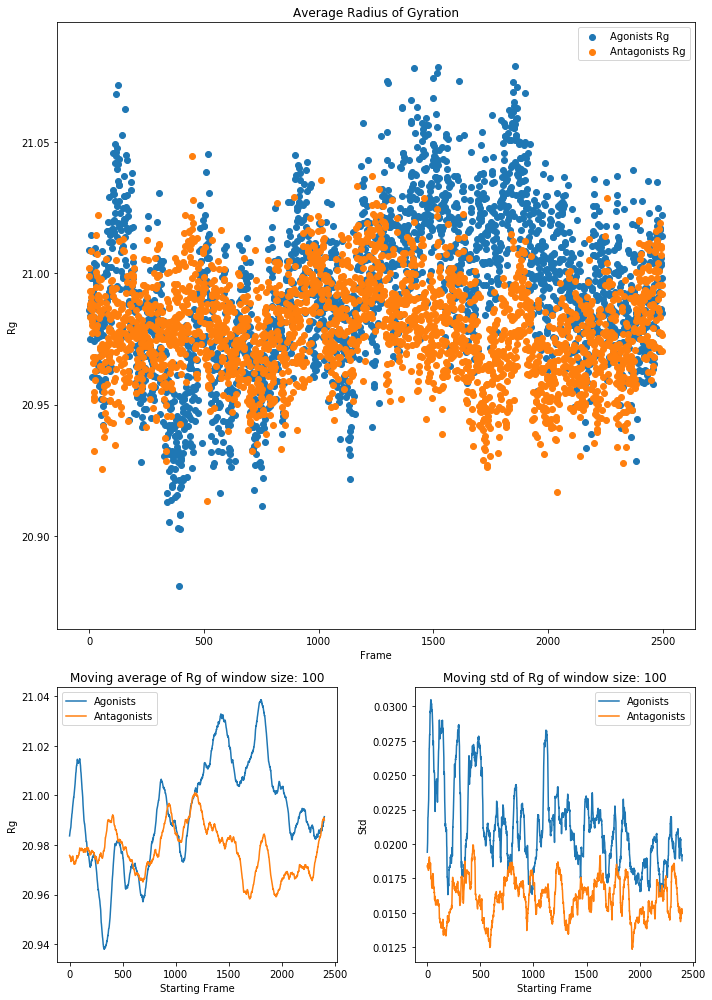

In [71]:
def calculate_average_cols_rg(analysis_actors_dict):
    '''
    Calculates the mean of Rg of each frame for all the agonists.
    Then does the same for the antagonists.
    
    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[DirectoryPath (str), AnalysisActor.class]
                                "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
                              )
    
    Returns:
        Tuple(np.array[#frames], np.array[#frames])
    '''
    stacked_agonists = analysis_actors_dict['Agonists'][0][1].rg_res
    for which_drug in analysis_actors_dict['Agonists'][1:]:
        stacked_agonists = np.vstack((stacked_agonists, which_drug[1].rg_res))
    avg_agonists_cols = np.mean(stacked_agonists, axis=0)
    
    stacked_antagonists = analysis_actors_dict['Antagonists'][0][1].rg_res
    for which_drug in analysis_actors_dict['Antagonists'][1:]:
        stacked_antagonists = np.vstack((stacked_antagonists, which_drug[1].rg_res))
    avg_antagonists_cols = np.mean(stacked_antagonists, axis=0)

    return (avg_agonists_cols, avg_antagonists_cols)


agon_rg_avg, antagon_rg_avg = calculate_average_cols_rg(analysis_actors_dict)

fig = plt.figure(figsize=(10, 14))
gs = GridSpec(3, 2, figure=fig)

# Plot frame averaged scatter plots of agonists vs antagonists
ax = fig.add_subplot(gs[0:2,:])
ax.scatter(np.arange(agon_rg_avg.shape[0]), agon_rg_avg, label="Agonists Rg")
ax.scatter(np.arange(agon_rg_avg.shape[0]), antagon_rg_avg, label="Antagonists Rg")
ax.set_ylabel('Rg')
ax.set_xlabel('Frame')
ax.legend()
plt.title("Average Radius of Gyration")

# Calculate and plot the moving average of the series
ax = fig.add_subplot(gs[2,0])
moving_average_window = 100
moving_average_agon = [np.mean(agon_rg_avg[i:i + moving_average_window]) for i in range(len(agon_rg_avg) - moving_average_window)]
moving_average_antagon = [np.mean(antagon_rg_avg[i:i + moving_average_window]) for i in range(len(antagon_rg_avg) - moving_average_window)]
ax.plot(moving_average_agon, label="Agonists")
ax.plot(moving_average_antagon, label="Antagonists")
ax.set_ylabel('Rg')
ax.set_xlabel('Starting Frame')
ax.legend()
plt.title(f"Moving average of Rg of window size: {moving_average_window}")

#  Calculate and plot the moving standard deviation of the series 
ax = fig.add_subplot(gs[2,1])
std_window = 100
stds_agon = [np.std(agon_rg_avg[i:i + std_window]) for i in range(len(agon_rg_avg) - std_window)]
stds_antagon = [np.std(antagon_rg_avg[i:i + std_window]) for i in range(len(antagon_rg_avg) - std_window)]
ax.plot(stds_agon, label="Agonists")
ax.plot(stds_antagon, label="Antagonists")
ax.set_ylabel('Std')
ax.set_xlabel('Starting Frame')
ax.legend()
plt.title(f"Moving std of Rg of window size: {std_window}")

plt.tight_layout()
plt.savefig("figures/Rg/rg_averaged_mean_std.png")
plt.show()



We observe the antagonists not having any great deviations from the average $Rg$ throughout the simulation. However, in the case of the agonists we observe a consistent increase of $Rg$ from frames 1300 - 2100 .

####  Increasing Window - Frame Averaged Distributions

The above plot is a bit cluttered so we will see if there is an actual difference by visualizing their distributions. We will also test the distributions as the frame window increases, e.g. frames 0 - 500, 0 - 1000, etc.  
We do that so as to be able to find when would be the earliest point (on average) that we start observing a difference on $Rg$. 

In [ ]:
added_window_size = 500    # We will see how as the  window size increases the distributions differ
nrows = np.ceil(len(agon_rg_avg) / added_window_size).astype('int32')
ncols = 2    # First column: Density, Second column: Boxplots

fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(11,20))

for which_plot in range(nrows):
    # Decide if there is a significant difference in the mean of agonists and antagonists
    # using a t-test. We could also use a Kolmogorov-Smirnov test although I think in our case
    # will not make difference.
    __, pvalue = stats.ttest_ind(agon_rg_avg[:(which_plot + 1) * added_window_size], 
                                 antagon_rg_avg[:(which_plot + 1) * added_window_size], 
                                 equal_var=False)
    significant_difference = "Yes" if pvalue < 0.05 else "No"
    
    # Plot the density functions
    ax = sns.distplot(agon_rg_avg[:(which_plot + 1) * added_window_size], color="blue", ax=axs[which_plot, 0], label="Agonists")
    ax = sns.distplot(antagon_rg_avg[:(which_plot + 1) * added_window_size], color="orange", ax=axs[which_plot, 0], label="Antagonists")
    ax.axvline(x = np.mean(agon_rg_avg[:(which_plot + 1) * added_window_size]), color="blue", alpha=0.3, ls="--")    # Vline showing mean of agonists
    ax.axvline(x = np.mean(antagon_rg_avg[:(which_plot + 1) * added_window_size]), color="orange", alpha=0.5, ls="--")    # Vline showing mean of antagonists

    ax.set(xlabel='Rg', ylabel='Frames')
    ax.set_title(f"Rg Density | Frames: 0 - {(which_plot + 1) * added_window_size} | Significant Difference = {significant_difference}")
    ax.legend()
    
    # Plot the boxplots
    boxplots_df = pd.DataFrame(np.array([agon_rg_avg[:(which_plot + 1) * added_window_size], 
                                         antagon_rg_avg[:(which_plot + 1) * added_window_size]]).T, 
                                         columns=['Agonists', 'Antagonists'])
    ax = sns.boxplot(data=boxplots_df, ax=axs[which_plot, 1])
    ax.set(xlabel='Ligand Type', ylabel='Rg')
    ax.set_title(f"Rg Boxplots | Frames: 0 - {(which_plot + 1) * added_window_size}")

fig.tight_layout()
plt.savefig("figures/Rg/rg_density_boxplots.png")
plt.show()

####  Rolling Window - Frame Averaged Distributions


We will now do the same as above but instead of having our window just increasing in size an not moving, we will now have a rolling window of constant size. The step of our rolling will be the same as the window size.

In [ ]:
constant_window_size = 500    # We will now keep the window size constant and roll it over our frames
nrows = np.ceil(len(agon_rg_avg) / constant_window_size).astype('int32')
ncols = 2    # First column: Density, Second column: Boxplots

fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(11,20))

for which_plot in range(nrows):
    # Decide if there is a significant difference in the mean of agonists and antagonists
    # using a t-test. We could also use a Kolmogorov-Smirnov test although I think in our case
    # will not make difference.     
    __, pvalue = stats.ttest_ind(agon_rg_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size], 
                                 antagon_rg_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size], 
                                 equal_var=False)
    significant_difference = "Yes" if pvalue < 0.05 else "No"
    
    # Plot the density functions
    ax = sns.distplot(agon_rg_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size], color="blue", ax=axs[which_plot, 0], label="Agonists")
    ax = sns.distplot(antagon_rg_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size], color="orange", ax=axs[which_plot, 0], label="Antagonists")
    ax.axvline(x = np.mean(agon_rg_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size]), color="blue", alpha=0.3, ls="--")    # Vline showing mean of agonists
    ax.axvline(x = np.mean(antagon_rg_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size]), color="orange", alpha=0.5, ls="--")    # Vline showing mean of antagonists
    
    ax.set(xlabel='Rg', ylabel='Frames')
    ax.set_title(f"Rg Density | Frames: {which_plot * constant_window_size} - {(which_plot + 1) * constant_window_size} | Significant Difference = {significant_difference}")
    ax.legend()
    
    # Plot the boxplots
    boxplots_df = pd.DataFrame(np.array([agon_rg_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size], 
                                         antagon_rg_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size]]).T, 
                                         columns=['Agonists', 'Antagonists'])
    ax = sns.boxplot(data=boxplots_df, ax=axs[which_plot, 1])
    ax.set(xlabel='Ligand Type', ylabel='Rg')
    ax.set_title(f"Rg Boxplots | Frames: {which_plot * constant_window_size} - {(which_plot + 1) * constant_window_size}")

fig.tight_layout()
plt.savefig("figures/Rg/rg_density_boxplots_rolling.png")
plt.show()

#### LDA

The LDA technique is developed to transform the features into a **lower dimensional space**, which maximizes the ratio of the between-class variance to the within-class variance, thereby guaranteeing **maximum class separability**.  
  
**Between-class variance**: The distance between the means of each class, that we want to **maximize**
**Within-class variance**: The "scatter" of the class, that we want to minimize  
[(ref)](https://www.researchgate.net/publication/316994943_Linear_discriminant_analysis_A_detailed_tutorial)  

$$ \underset{W}{\operatorname{argmax}} \frac{W^TS_bW}{W^TS_wW} $$
$S_b$ the between-class variance  
$S_w$ the within-class variance  
$W$ the transformation matrix we use for the dimensionality reduction  

In [ ]:
# First stack the agonists and the antagonists Rg to create our temporary dataset
# Rows: #Agonists + #Antagonists
# Columns: # Frames

# Stacking the agonists and the antagonists Rg value for each frame
ligands = [analysis_actors_dict['Agonists'], analysis_actors_dict['Antagonists']]
rg_stacked_values = np.array([which_drug[1].get_radius_of_gyration() for which_drug in itertools.chain(*ligands)])

# Creating an array of labels: 0->Agonist, 1->Antagonis
ligand_labels = [0 for i in analysis_actors_dict['Agonists']] + [1 for i in analysis_actors_dict['Antagonists']]

# Perform LDA over all the frames
lda = LinearDiscriminantAnalysis(n_components=1)
reduced = lda.fit_transform(rg_stacked_values, ligand_labels)
mean_value_agon = np.mean(reduced[:len(analysis_actors_dict['Agonists'])])
mean_value_antagon = np.mean(reduced[len(analysis_actors_dict['Agonists']):])

plt.rcParams["figure.figsize"] = (12,2)
plt.plot(reduced[len(analysis_actors_dict['Agonists']):], np.zeros_like(analysis_actors_dict['Antagonists']), 'o', color = "orange", label="Antagonists")
plt.plot(reduced[:len(analysis_actors_dict['Agonists'])], np.zeros_like(analysis_actors_dict['Agonists']), 'x', color="blue", label="Agonists")
plt.vlines(mean_value_agon, ymax=0.02, ymin=0, alpha=0.5, color="blue")
plt.vlines(mean_value_antagon, ymax=0.02, ymin=0, alpha=0.5, color="orange")


plt.title("LDA on Rg over all frames")
plt.grid()
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

# Perform LDA over the optimal frames 1500 - 2000
lda = LinearDiscriminantAnalysis(n_components=1)
reduced = lda.fit_transform(rg_stacked_values[:,500:1000], ligand_labels)
mean_value_agon = np.mean(reduced[:len(analysis_actors_dict['Agonists'])])
mean_value_antagon = np.mean(reduced[len(analysis_actors_dict['Agonists']):])

plt.rcParams["figure.figsize"] = (12,2)
plt.plot(reduced[len(analysis_actors_dict['Agonists']):], np.zeros_like(analysis_actors_dict['Antagonists']), 'o', color = "orange", label="Antagonists")
plt.plot(reduced[:len(analysis_actors_dict['Agonists'])], np.zeros_like(analysis_actors_dict['Agonists']), 'x', color="blue", label="Agonists")
plt.vlines(mean_value_agon, ymax=0.02, ymin=0, alpha=0.5, color="blue")
plt.vlines(mean_value_antagon, ymax=0.02, ymin=0, alpha=0.5, color="orange")

plt.title("LDA on Rg over optimal frames (500 - 1000)")
plt.grid()
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

We observe that LDA does not manage to achieve great separability since our input (the progression of Rg values) is not enough. One main pitfall is the Small Sample Size problem (SSS). Since, our dataset has a small number of points we have trouble being certain about our observations since most bayesian methods need a large dataset [(Law of large numbers)](https://en.wikipedia.org/wiki/Law_of_large_numbers). 

#### Ligand Average and Std

Since our main goal is to be able to differentiate agonists from antagonists we want to find a way to use the $Rg$ as a feature. There are many possible ways to extract features from $Rg$. The most straight-forward are the mean and the standard deviation of the $Rg$ of each ligand.

In [89]:
def calculate_rg_mean_std(analysis_actors_dict, window_start=0, window_size=2500):
    """
    Will calculate the average and the std Rg of every ligand on the specified window
    
    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[DirectoryPath (str), AnalysisActor.class]
                                "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
                              )
        window_start(int): The first frame of our window (0-based)
        
        window_size(int): How many frames to include from the window_start.
                          Care: window_start + window_size < total_frames must becovered
                          
    Returns: Dict(
                    "Agonists": numpy.array[Rg_mean, Rg_std],
                    "Antagonists":numpy.array[Rg_mean, Rg_std]
                 )
    """
    rg_dict = {"Agonists": [], "Antagonists": []}
    
    # Iterate on the agonists
    for which_drug in analysis_actors_dict['Agonists']:
        drug_avg = np.mean(which_drug[1].get_radius_of_gyration()[window_start:window_start + window_size])
        drug_std = np.std(which_drug[1].get_radius_of_gyration()[window_start:window_start + window_size])
        
        rg_dict["Agonists"].append([drug_avg, drug_std])
        
    # Iterate on the antagonists
    for which_drug in analysis_actors_dict['Antagonists']:
        drug_avg = np.mean(which_drug[1].get_radius_of_gyration()[window_start:window_start + window_size])
        drug_std = np.std(which_drug[1].get_radius_of_gyration()[window_start:window_start + window_size])
        
        rg_dict["Antagonists"].append([drug_avg, drug_std])
        
    # Transform lists to numpy arrays for usability
    rg_dict["Agonists"] = np.array(rg_dict["Agonists"])
    rg_dict["Antagonists"] = np.array(rg_dict["Antagonists"])
    
    return rg_dict

To evaluate our metrics we will create scatter plots that on the x-axis we will have the average $Rg$ of each ligand and on the y-axis the standard deviation of each ligand.  
We will create different plots for different windows eg 0 - 2.500, 0 - 1.250, 1.250 - 2.000.

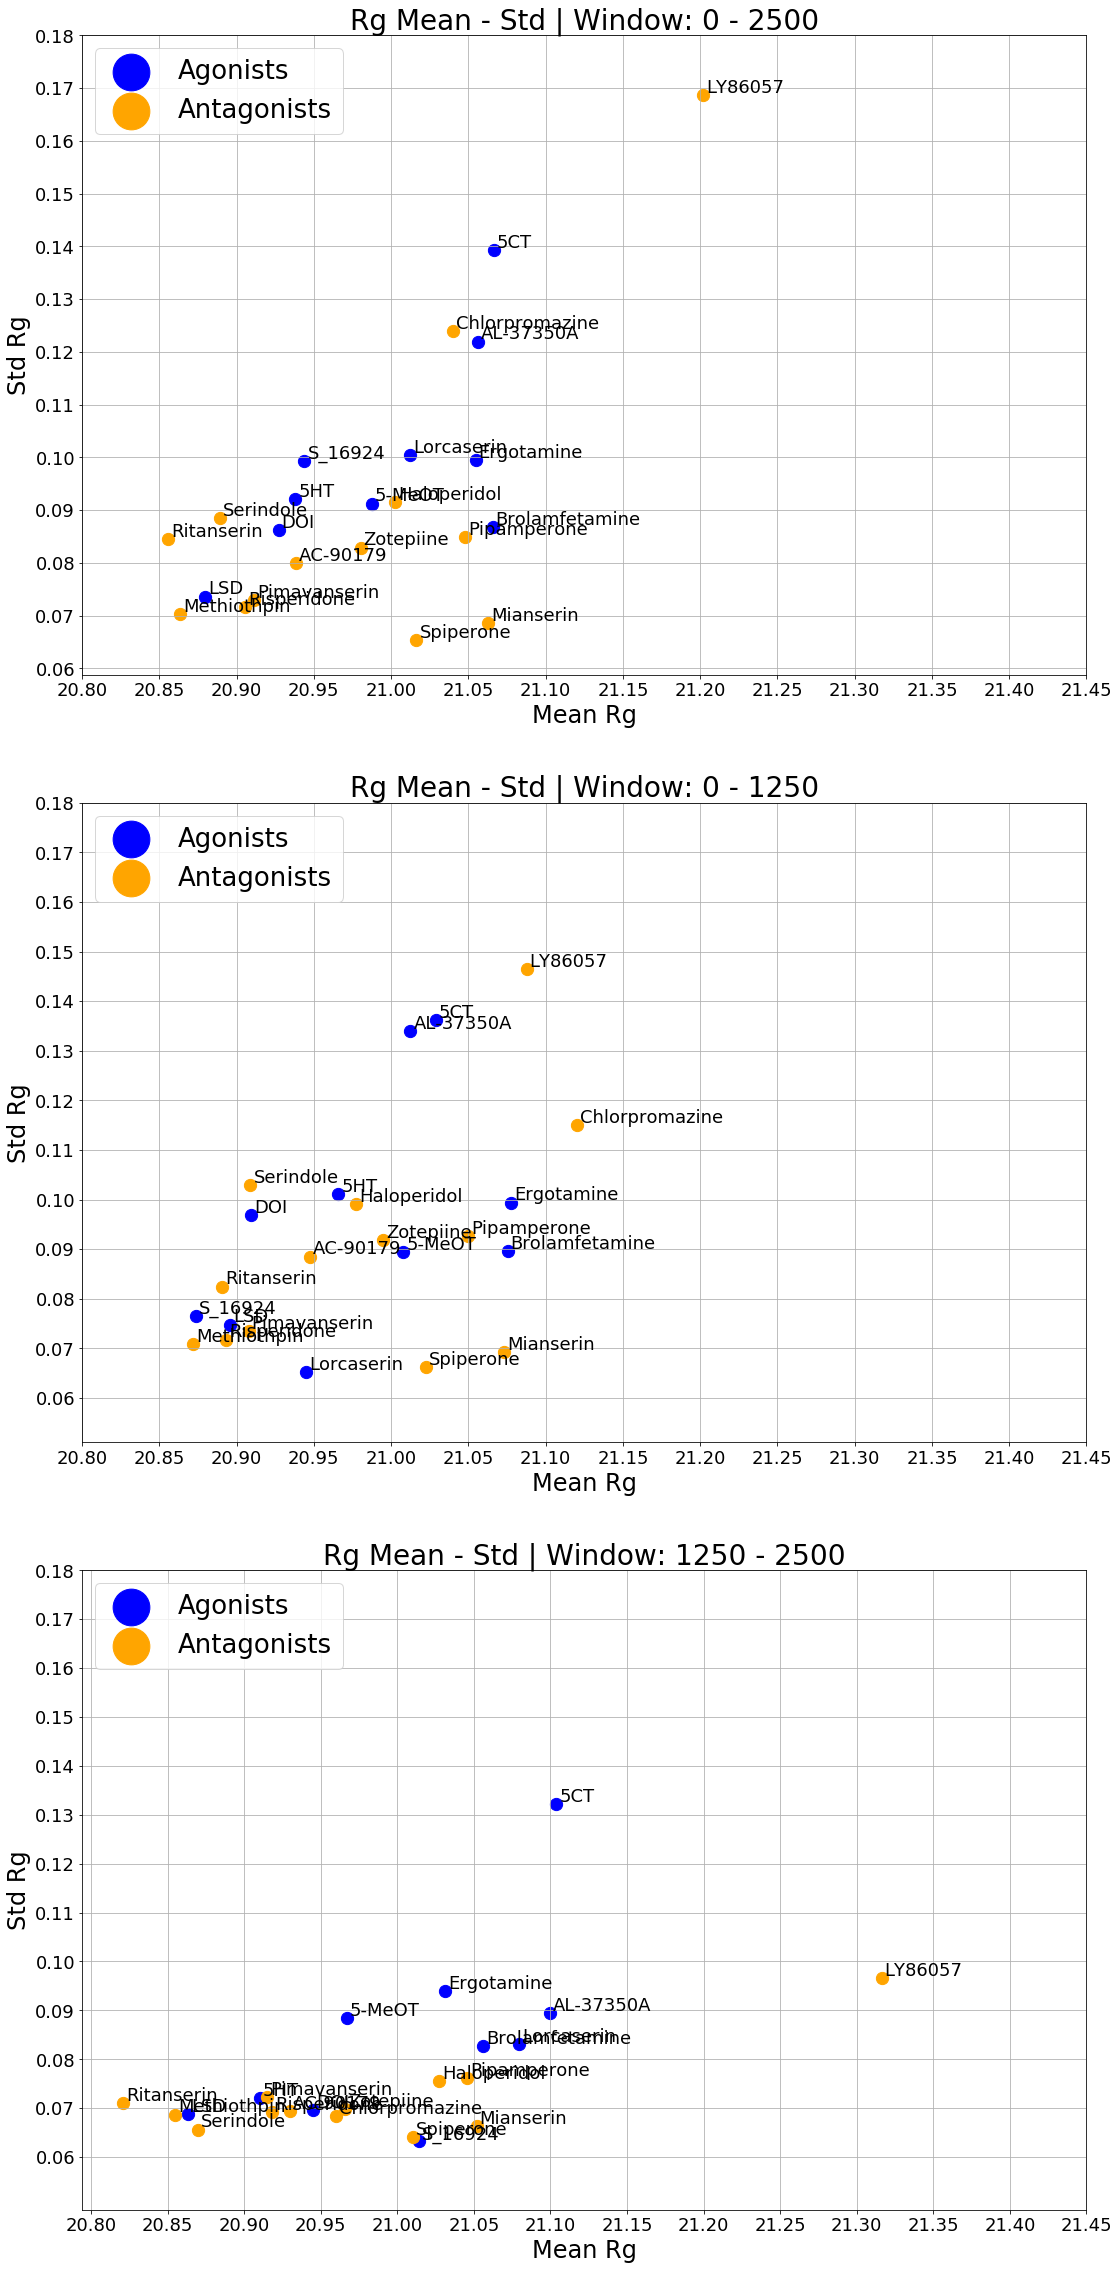

In [90]:
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# List of windows that will be plotted of [window_start, window_size]
windows_arguments = [[0, 2500], [0, 1250], [1250, 1250]]

for window_arg in windows_arguments:
    # Calculate the meand and the std of all the ligands on the specified frame window
    rg_avg_std_0_2500 = calculate_rg_mean_std(analysis_actors_dict, window_arg[0], window_arg[1])

    ax = fig.add_subplot(3, 1, plot_index)
    plt.scatter(rg_avg_std_0_2500['Agonists'][:, 0], rg_avg_std_0_2500['Agonists'][:,1], label="Agonists", color="blue", s=150)
    plt.scatter(rg_avg_std_0_2500['Antagonists'][:, 0], rg_avg_std_0_2500['Antagonists'][:,1], label="Antagonists", color="orange", s=150)

    # Annotate the plot by putting the name of the ligand on each dot
    for which_drug in range(len(analysis_actors_dict['Agonists'])):
        ax.annotate(analysis_actors_dict['Agonists'][which_drug][1].drug_name, 
                    (rg_avg_std_0_2500['Agonists'][:, 0][which_drug] + 0.002, 
                     rg_avg_std_0_2500['Agonists'][:, 1][which_drug] + 0.0005),
                     fontsize=18)

    for which_drug in range(len(analysis_actors_dict['Antagonists'])):
        ax.annotate(analysis_actors_dict['Antagonists'][which_drug][1].drug_name, 
                    (rg_avg_std_0_2500['Antagonists'][:, 0][which_drug] + 0.002, 
                     rg_avg_std_0_2500['Antagonists'][:, 1][which_drug] + 0.0005),
                     fontsize=18)

    plt.xlabel("Mean Rg", fontsize=24)
    plt.xticks(np.arange(20.8, 21.5, 0.05), fontsize=18)
    plt.yticks(np.arange(0.06, 0.19, 0.01), fontsize=18)
    plt.ylabel("Std Rg", fontsize=24)
    plt.title(f"Rg Mean - Std | Window: {window_arg[0]} - {window_arg[0] + window_arg[1]}", fontsize=28)
    plt.legend(prop={'size': 26}, markerscale=3, loc=2)
    plt.grid()
    
    plot_index += 1

plt.savefig('figures/Rg/rg_mean_std.png', format='png')
plt.show()

We observe **mainly the standard deviation** and not so much the mean of the $Rg$ to have a differentiating role between the agonists and the antagonists. This is more clear on the frame window 1.250 - 2.500 which is expected since we believe that this is the window that the event is happening.  
We also notice that **LY86057** is an outlier.

#### Combined Plots

On this section of the notebook, I will plot all the Rg plots of the agonists and the antagonists together in one plot in order to make it easier to observe any obvious differences on trends that might not be noticeable using the mean and standard deviation above.

In [ ]:
fig = plt.figure(figsize=(18, 20))
step = 20

for which_drug in analysis_actors_dict['Agonists']:
    plt.plot(np.arange(len(which_drug[1].get_radius_of_gyration()[::step]))* step, which_drug[1].get_radius_of_gyration()[::step], color="blue", label="Agonists", alpha=0.5)
    
for which_drug in analysis_actors_dict['Antagonists']:
    plt.plot(np.arange(len(which_drug[1].get_radius_of_gyration()[::step])) * step, which_drug[1].get_radius_of_gyration()[::step], color="orange", label="Antagonists", alpha=0.5)

plt.xlabel("Frame", fontsize=18)
plt.ylabel("Rg", fontsize=18)
plt.title(f"Rg Combined Plots | Agonists: Blue, Antagonists: Orange | Step {step}", fontsize=18)

plt.show()

#### Linear Regression

The above plot is way too cluttered in order to have any new insights. For this reason I will fit on each trajectory a linear regression model on its $Rg$ values. This way, if we observe any separability between the resulted lines we could use the coefficient as a feature.

In [ ]:
# Plot one line and Rg series as an example
rg = analysis_actors_dict['Agonists'][5][1].get_radius_of_gyration()
rg_X = np.arange(len(rg))[:,np.newaxis]

# Fit a 1st degree linear regression model
lreg = LinearRegression().fit(rg_X, rg)

# Predict on the rg_X in order to get points of the line
predicted = lreg.predict(rg_X)

plt.plot(np.arange(len(rg)), rg, color="orange")
plt.plot(np.arange(len(rg)), predicted, color="blue")

plt.title(f'{analysis_actors_dict["Agonists"][5][1].drug_name} | Coefficient: {np.round(lreg.coef_[0], decimals=8)}')
plt.show()

In [ ]:
fig = plt.figure(figsize=(18, 30))

# Iterate on the agonists
for which_drug in analysis_actors_dict['Agonists']:
    rg = which_drug[1].get_radius_of_gyration()
    rg_X = np.arange(len(rg))[:,np.newaxis]
    
    # Fit a 1st degree linear regression model
    lreg = LinearRegression().fit(rg_X, rg)

    # Predict on the rg_X in order to get points of the line
    predicted = lreg.predict(rg_X)
    
    plt.plot(np.arange(len(rg)), predicted, color="blue")
    plt.annotate(which_drug[1].drug_name, (2300, predicted[2300]))
    
# Iterate on the antagonsits
for which_drug in analysis_actors_dict['Antagonists']:
    rg = which_drug[1].get_radius_of_gyration()
    rg_X = np.arange(len(rg))[:,np.newaxis]
    
    # Fit a 1st degree linear regression model
    lreg = LinearRegression().fit(rg_X, rg)

    # Predict on the rg_X in order to get points of the line
    predicted = lreg.predict(rg_X)
    
    plt.plot(np.arange(len(rg)), predicted, color="orange")
    plt.annotate(which_drug[1].drug_name, (2300, predicted[2300]))

plt.title("Linear Regression of 1st degree on Rg for each ligand", fontsize=18)
plt.xlabel("Frame", fontsize=18)
plt.ylabel("Rg", fontsize=18)

plt.savefig('figures/Rg/rg_linear_fitting.png', format='png')
plt.show()

We can see that although the agonists do not have necessarily a positive coefficient (5 are downwards and 5 are upwards), most of the antagonists do have a downwards or steady slope (10 out of 13). One big exception is the LY86057 outlier.

###  Solvent-Accessible Surface Area (SASA)
​  
The accessible surface area (ASA) or solvent-accessible surface area (SASA) is the surface area of a biomolecule that is accessible to a solvent [(ref)](http://compbio.biosci.uq.edu.au/mediawiki/upload/d/d5/Lee1971_JMolBiol55-379.pdf). Measurement of SASA is usually **described in units of square Ångstroms**. SASA is typically calculated using the 'rolling ball' algorithm developed by Shrake & Rupley in 1973. This algorithm uses a sphere (of solvent) of a particular radius to 'probe' the surface of the molecule [(ref)](https://www.sciencedirect.com/science/article/abs/pii/0022283673900119?via%3Dihub).
​  
​  
Changes of SASA indicate a change in the conformation of the protein and unfolding.

<img src="https://drive.google.com/uc?export=view&id=17CHp_-xbBPDuRM13SmvmCMpc4Y1i2jwS" alt="drawing" width="200"/>

*Currently the SASAs were calculated using **GROMACS** before running the notebook. There is a [function on MDTraj](http://mdtraj.org/1.6.2/api/generated/mdtraj.shrake_rupley.html) package that can be used but my laptop was not able to handle its memory usage*  
  
[Gromacs command](http://manual.gromacs.org/documentation/5.1/onlinehelp/gmx-sasa.html): `gmx sasa -f trajecotry.xtc -s topology.pdb -o sasa.xvg`

#### Separate Plots

I opted to use the same workflow as I did with $Rg$. So firstly, I will create the separate plots and then combine them on the same plot using the average SASA of each frame.

In [ ]:
# We create plot of the SASA as frames progress for each drug
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Agonists Iteration
for which_drug in analysis_actors_dict['Agonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(which_drug[1].get_frames_number()), which_drug[1].sasa_res[1], label="SASA")
    plt.ylabel("SASA")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

# Antagonists Iteration
for which_drug in analysis_actors_dict['Antagonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(which_drug[1].get_frames_number()), which_drug[1].sasa_res[1], label="SASA", color='orange')
    plt.ylabel("SASA")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

fig.suptitle('Solvent Accessible Surface Area\nAgonists: Blue\nAntagonists: Orange', fontsize=26, y = 0.93)

plt.show()

#### Frame Averaged Plot

To have more intuition if **SASA** has any important signal for differentiating agonists/antagonists:
1. Create an **average** SASA of each frame of the **agonists**
2. Create an **average** SASA of each frame of the **antagonists**
3. Plot them on the same figure

*TODO: the `calculate_average_cols_metric` methods are similar and should be combined into one more general.* 

In [ ]:
def calculate_average_cols_sasa(analysis_actors_dict):
    '''
    Calculates the mean of SASA of each frame for all the agonists.
    Then does the same for the antagonists.
    
    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[DirectoryPath (str), AnalysisActor.class]
                                "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
                              )
    
    Returns:
        Tuple(np.array[#frames], np.array[#frames])
    '''
    stacked_agonists = analysis_actors_dict['Agonists'][0][1].sasa_res[1]
    for which_drug in analysis_actors_dict['Agonists'][1:]:
        stacked_agonists = np.vstack((stacked_agonists, which_drug[1].sasa_res[1]))
    avg_agonists_cols = np.mean(stacked_agonists, axis=0)
    
    stacked_antagonists = analysis_actors_dict['Antagonists'][0][1].sasa_res[1]
    for which_drug in analysis_actors_dict['Antagonists'][1:]:
        stacked_antagonists = np.vstack((stacked_antagonists, which_drug[1].sasa_res[1]))
    avg_antagonists_cols = np.mean(stacked_antagonists, axis=0)

    return (avg_agonists_cols, avg_antagonists_cols)

agon_sasa_avg, antagon_sasa_avg = calculate_average_cols_sasa(analysis_actors_dict)

fig = plt.figure(figsize=(10, 14))
gs = GridSpec(3, 2, figure=fig)

# Plot frame averaged scatter plots of agonists vs antagonists
ax = fig.add_subplot(gs[0:2,:])
ax.scatter(np.arange(agon_sasa_avg.shape[0]), agon_sasa_avg, label="Agonists SASA")
ax.scatter(np.arange(antagon_sasa_avg.shape[0]), antagon_sasa_avg, label="Antagonists SASA")
ax.set_ylabel('SASA (A^2)')
ax.set_xlabel('Frame')
ax.legend()
plt.title("Average Solvent Accessible Surface Area")

# Calculate and plot the moving average of the series
ax = fig.add_subplot(gs[2,0])
moving_average_window = 100
moving_average_agon = [np.mean(agon_sasa_avg[i:i + moving_average_window]) for i in range(len(agon_sasa_avg) - moving_average_window)]
moving_average_antagon = [np.mean(antagon_sasa_avg[i:i + moving_average_window]) for i in range(len(antagon_sasa_avg) - moving_average_window)]
ax.plot(moving_average_agon, label="Agonists")
ax.plot(moving_average_antagon, label="Antagonists")
ax.set_ylabel('SASA')
ax.set_xlabel('Starting Frame')
ax.legend()
plt.title(f"Moving average of SASA of window size: {moving_average_window}")

#  Calculate and plot the moving standard deviation of the series 
ax = fig.add_subplot(gs[2,1])
std_window = 100
stds_agon = [np.std(agon_sasa_avg[i:i + std_window]) for i in range(len(agon_sasa_avg) - std_window)]
stds_antagon = [np.std(antagon_sasa_avg[i:i + std_window]) for i in range(len(antagon_sasa_avg) - std_window)]
ax.plot(stds_agon, label="Agonists")
ax.plot(stds_antagon, label="Antagonists")
ax.set_ylabel('Std')
ax.set_xlabel('Starting Frame')
ax.legend()
plt.title(f"Moving std of SASA of window size: {std_window}")

plt.tight_layout()

plt.savefig('figures/SASA/sasa_averaged_mean_std.png')
plt.show()

This time we observe the agonists have a small increase on their SASA (frames 1800 - 2200). However, this time we also observe the SASA of the antagonists decreasing (frames 1500 - 2200) showing an **inverse correlation** between the $Rg$ of the agonists and the SASA of the antagonists.

####  Increasing Window - Frame Averaged Distributions

As with $Rg$ I will create the plots of an increasing size window of frames (0 - 500, 0 - 1.000, ..., 0 - 2.500). On each window I will check if the mean of agonists and the antagonists is significantly different using a Student's t-test.

In [ ]:
added_window_size = 500    # We will see how as the  window size increases the distributions differ
nrows = np.ceil(len(agon_sasa_avg) / added_window_size).astype('int32')
ncols = 2    # First column: Density, Second column: Boxplots

fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(11,20))

for which_plot in range(nrows):
    # Decide if there is a significant difference in the mean of agonists and antagonists
    # using a t-test. We could also use a Kolmogorov-Smirnov test although I think in our case
    # will not make difference.
    __, pvalue = stats.ttest_ind(agon_sasa_avg[:(which_plot + 1) * added_window_size], 
                                 antagon_sasa_avg[:(which_plot + 1) * added_window_size], 
                                 equal_var=False)
    significant_difference = "Yes" if pvalue < 0.05 else "No"
    
    # Plot the density functions
    ax = sns.distplot(agon_sasa_avg[:(which_plot + 1) * added_window_size], color="blue", ax=axs[which_plot, 0], label="Agonists")
    ax = sns.distplot(antagon_sasa_avg[:(which_plot + 1) * added_window_size], color="orange", ax=axs[which_plot, 0], label="Antagonists")
    ax.axvline(x = np.mean(agon_sasa_avg[:(which_plot + 1) * added_window_size]), color="blue", alpha=0.3, ls="--")    # Vline showing mean of agonists
    ax.axvline(x = np.mean(antagon_sasa_avg[:(which_plot + 1) * added_window_size]), color="orange", alpha=0.5, ls="--")    # Vline showing mean of antagonists

    ax.set(xlabel='SASA', ylabel='Frames')
    ax.set_title(f"SASA Density | Frames: 0 - {(which_plot + 1) * added_window_size} | Significant Difference = {significant_difference}")
    ax.legend()
    
    # Plot the boxplots
    boxplots_df = pd.DataFrame(np.array([agon_sasa_avg[:(which_plot + 1) * added_window_size], 
                                         antagon_sasa_avg[:(which_plot + 1) * added_window_size]]).T, 
                                         columns=['Agonists', 'Antagonists'])
    ax = sns.boxplot(data=boxplots_df, ax=axs[which_plot, 1])
    ax.set(xlabel='Ligand Type', ylabel='SASA')
    ax.set_title(f"SASA Boxplots | Frames: 0 - {(which_plot + 1) * added_window_size}")

fig.tight_layout()
plt.savefig("figures/SASA/sasa_density_boxplots.png")
plt.show()

#### Rolling Window - Frame Averaged Plots

In [ ]:
constant_window_size = 500    # We will now keep the window size constant and roll it over our frames
nrows = np.ceil(len(agon_sasa_avg) / constant_window_size).astype('int32')
ncols = 2    # First column: Density, Second column: Boxplots

fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(11,20))

for which_plot in range(nrows):
    # Decide if there is a significant difference in the mean of agonists and antagonists
    # using a t-test. We could also use a Kolmogorov-Smirnov test although I think in our case
    # will not make difference.     
    __, pvalue = stats.ttest_ind(agon_sasa_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size], 
                                 antagon_sasa_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size], 
                                 equal_var=False)
    significant_difference = "Yes" if pvalue < 0.05 else "No"
    
    # Plot the density functions
    ax = sns.distplot(agon_sasa_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size], color="blue", ax=axs[which_plot, 0], label="Agonists")
    ax = sns.distplot(antagon_sasa_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size], color="orange", ax=axs[which_plot, 0], label="Antagonists")
    ax.axvline(x = np.mean(agon_sasa_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size]), color="blue", alpha=0.3, ls="--")    # Vline showing mean of agonists
    ax.axvline(x = np.mean(antagon_sasa_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size]), color="orange", alpha=0.5, ls="--")    # Vline showing mean of antagonists
    
    ax.set(xlabel='SASA', ylabel='Frames')
    ax.set_title(f"SASA Density | Frames: {which_plot * constant_window_size} - {(which_plot + 1) * constant_window_size} | Significant Difference = {significant_difference}")
    ax.legend()
    
    # Plot the boxplots
    boxplots_df = pd.DataFrame(np.array([agon_sasa_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size], 
                                         antagon_sasa_avg[which_plot * constant_window_size:(which_plot + 1) * constant_window_size]]).T, 
                                         columns=['Agonists', 'Antagonists'])
    ax = sns.boxplot(data=boxplots_df, ax=axs[which_plot, 1])
    ax.set(xlabel='Ligand Type', ylabel='Rg')
    ax.set_title(f"SASA Boxplots | Frames: {which_plot * constant_window_size} - {(which_plot + 1) * constant_window_size}")

fig.tight_layout()
plt.savefig("figures/SASA/sasa_density_boxplots_rolling.png")
plt.show()

What are we observing?

* At the starting point (window 0 - 500) on average the agonists have a smaller SASA than the antagonists. This has probably something to do with the structure of the ligands.
* As the simulation progresses the mean SASA of the antagonists decreases and on the window 1.500 - 2.000 we have a the mean of the agonists being greater than the mean of the antagonists.

#### Ligand Average and Std

Since SASA and Rg result into a 2500 frames timeseries I am following a similar approach. So I will calculate the SASA mean and std in order to observe how differentiating they are as features.

In [35]:
def calculate_sasa_mean_std(analysis_actors_dict, window_start=0, window_size=2500):
    """
    Will calculate the average and the std SASA of every ligand on the specified window
    
    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[DirectoryPath (str), AnalysisActor.class]
                                "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
                              )
        window_start(int): The first frame of our window (0-based)
        
        window_size(int): How many frames to include from the window_start.
                          Care: window_start + window_size < total_frames must becovered
                          
    Returns: Dict(
                    "Agonists": numpy.array[SASA_mean, SASA_std],
                    "Antagonists":numpy.array[SASA_mean, SASA_std]
                 )
    """
    sasa_dict = {"Agonists": [], "Antagonists": []}
    
    # Iterate on the agonists
    for which_drug in analysis_actors_dict['Agonists']:
        drug_avg = np.mean(which_drug[1].get_sasa()[1][window_start:window_start + window_size])
        drug_std = np.std(which_drug[1].get_sasa()[1][window_start:window_start + window_size])
        
        sasa_dict["Agonists"].append([drug_avg, drug_std])
        
    # Iterate on the antagonists
    for which_drug in analysis_actors_dict['Antagonists']:
        drug_avg = np.mean(which_drug[1].get_sasa()[1][window_start:window_start + window_size])
        drug_std = np.std(which_drug[1].get_sasa()[1][window_start:window_start + window_size])
        
        sasa_dict["Antagonists"].append([drug_avg, drug_std])
        
    # Transform lists to numpy arrays for usability
    sasa_dict["Agonists"] = np.array(sasa_dict["Agonists"])
    sasa_dict["Antagonists"] = np.array(sasa_dict["Antagonists"])
    
    return sasa_dict

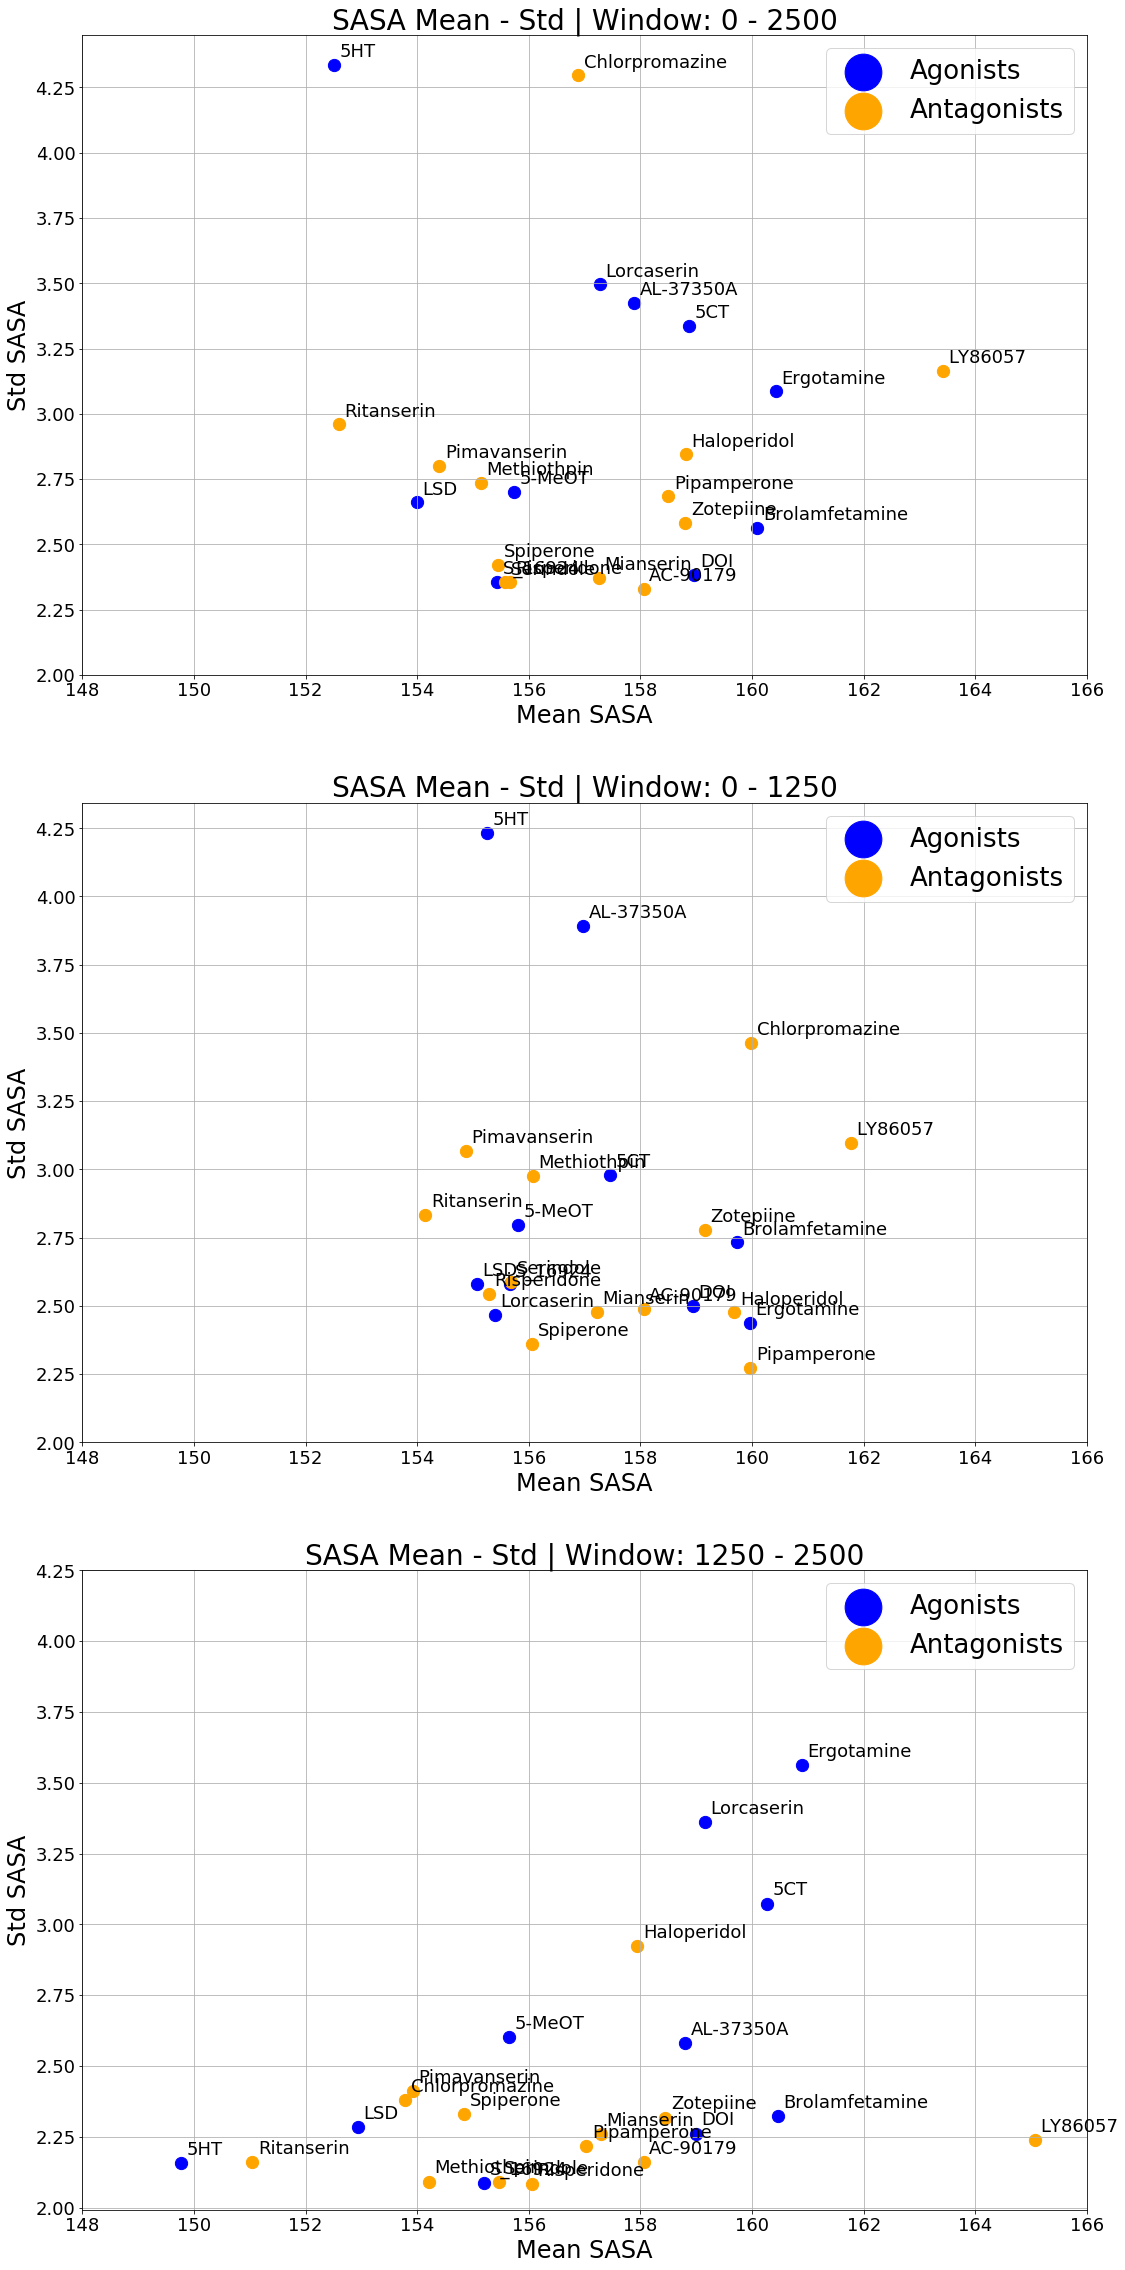

In [40]:
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# List of windows that will be plotted of [window_start, window_size]
windows_arguments = [[0, 2500], [0, 1250], [1250, 1250]]

for window_arg in windows_arguments:
    # Calculate the meand and the std of all the ligands on the specified frame window
    sasa_avg_std_0_2500 = calculate_sasa_mean_std(analysis_actors_dict, window_arg[0], window_arg[1])

    ax = fig.add_subplot(3, 1, plot_index)
    plt.scatter(sasa_avg_std_0_2500['Agonists'][:, 0], sasa_avg_std_0_2500['Agonists'][:,1], label="Agonists",color="blue", s=150)
    plt.scatter(sasa_avg_std_0_2500['Antagonists'][:, 0], sasa_avg_std_0_2500['Antagonists'][:,1], label="Antagonists", color="orange", s=150)

    # Annotate the plot by putting the name of the ligand on each dot
    for which_drug in range(len(analysis_actors_dict['Agonists'])):

        ax.annotate(analysis_actors_dict['Agonists'][which_drug][1].drug_name, 
                    (sasa_avg_std_0_2500['Agonists'][:, 0][which_drug] + 0.1, 
                     sasa_avg_std_0_2500['Agonists'][:, 1][which_drug] + 0.03),
                     fontsize=18)

    for which_drug in range(len(analysis_actors_dict['Antagonists'])):
        ax.annotate(analysis_actors_dict['Antagonists'][which_drug][1].drug_name, 
                    (sasa_avg_std_0_2500['Antagonists'][:, 0][which_drug]+ 0.1, 
                     sasa_avg_std_0_2500['Antagonists'][:, 1][which_drug] + 0.03),
                    fontsize=18)

    plt.xlabel("Mean SASA", fontsize=24)
    plt.xticks(np.arange(148, 168, 2), fontsize=18)
    plt.yticks(np.arange(2, 4.5, 0.25), fontsize=18)
    plt.ylabel("Std SASA", fontsize=24)
    plt.title(f"SASA Mean - Std | Window: {window_arg[0]} - {window_arg[0] + window_arg[1]}", fontsize=28)
    plt.legend(prop={'size': 26}, markerscale=3)
    plt.grid()
    
    plot_index += 1

plt.savefig('figures/SASA/sasa_mean_std.png', format='png')
plt.show()

#### Linear Regression

In [ ]:
fig = plt.figure(figsize=(18, 30))

# Iterate on the agonists
for which_drug in analysis_actors_dict['Agonists']:
    sasa = which_drug[1].get_sasa()[1]
    sasa_X = np.arange(len(rg))[:,np.newaxis]
    
    # Fit a 1st degree linear regression model
    lreg = LinearRegression().fit(sasa_X, sasa)

    # Predict on the rg_X in order to get points of the line
    predicted = lreg.predict(sasa_X)
    
    plt.plot(np.arange(len(sasa)), predicted, color="blue")
    plt.annotate(which_drug[1].drug_name, (2300, predicted[2300]))
    
# Iterate on the antagonsits
for which_drug in analysis_actors_dict['Antagonists']:
    sasa = which_drug[1].get_sasa()[1]
    sasa_X = np.arange(len(sasa))[:,np.newaxis]
    
    # Fit a 1st degree linear regression model
    lreg = LinearRegression().fit(sasa_X, sasa)

    # Predict on the rg_X in order to get points of the line
    predicted = lreg.predict(sasa_X)
    
    plt.plot(np.arange(len(sasa)), predicted, color="orange")
    plt.annotate(which_drug[1].drug_name, (2300, predicted[2300]))

plt.title("Linear Regression of 1st degree on SASA for each ligand", fontsize=18)
plt.xlabel("Frame", fontsize=18)
plt.ylabel("SASA", fontsize=18)

plt.savefig('figures/SASA/sasa_linear_fitting.png', format='png')

plt.show()

Almost all of the antagonists have a downwards slope with the exception of the outlier LY86057. Also, some of the agonists have an upwards slope (4 out of 10).

### Root Mean Square Flactuation (RMSF)

RMSF is a measure of the deviation of the position of a particle i with respect to a reference position **over time**.

**Difference between RMSD and RMSF**: The latter is averaged over time, giving a value for each particle i. For the RMSD the average is taken over the particles, giving time specific values. So **RMSD is time specific** and **RMSF is atom specific** [(ref)](http://www.drugdesign.gr/uploads/7/6/0/2/7602318/lecture_mdanalysis.pdf).

\begin{equation*}
RMSF_i = \left[ \frac{1}{T} \sum_{t_j=1}^T \mid r_i(t_j) - r_i^\text{ref} \mid ^ 2 \right] ^ \frac{1}{2}
\end{equation*}

$T$ is the total simulation time  
$r_i^\text{ref}$ is the reference position of particle $i$, eg. the **time-averaged** position of the same particle $i$  
$\mid r_i(t_j) - r_i^\text{ref} \mid$ is the Euclidean distance of particle $i$ on frame $j$ from $r_i^\text{ref}$

This time since our $x-axis$ are the residue ids, we will have a slightly different approach.
Our $y-axis$ will have the RMSF value of the residues specified by the $x-axis$.

#### Separate Plots

In [ ]:
# We create plot of the RMSF as residue id progresses for each drug
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Agonists Iteration
for which_drug in analysis_actors_dict['Agonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(which_drug[1].uni.atoms.resnums, which_drug[1].rmsf_res.rmsf, label="RMSF")
#     plt.plot(np.unique(which_drug[1].uni.atoms.resnums), get_avg_rmsf_per_residue(which_drug[1]), label="SASA")
    plt.xlabel("Residue Id")
    plt.ylabel("RMSF")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

# Antagonists Iteration
for which_drug in analysis_actors_dict['Antagonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(which_drug[1].uni.atoms.resnums, which_drug[1].rmsf_res.rmsf, label="RMSF", color='orange')
    plt.xlabel("Residue Id")
    plt.ylabel("RMSF")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

fig.suptitle('Root Mean Square Fluctuation\nAgonists: Blue\nAntagonists: Orange', fontsize=26, y = 0.93)

plt.show()

#### Residue Averaged Plot

As with the previous plots we average the columns although in this case each column is not a frame but a residue.

Since the dimensions do not much (different number of **atoms**) I decided to firstly calculate the average RMSF of each residue (which are on all of the drugs 291 since we are on the same receptor).
Then I calculate the average RMSF of the residues of all the agonists and then all of the antagonists.

Steps:
1. Calculate for each drug the average RMSF of each residue -> Reduces dimensionality to 291
2. Calculate the average of the result on step 1 for all the agonists
3. Calculate the average of the result on step 1 for all the antagonists
3. Plot them on the same figure


Since the above is a bit complicated I will explain it **using an example**.

Let's say we have 5 agonists.
Each agonist has **k number of atoms** but **291 residues**.  
What residue each atom belongs is given by a vector like: $[1, 1, 1, 2, 2, ..., 291, 291]_k^T$  
We also have a vector of RMSFs of each atom like $[3, 2, 7, 5, 8, ..., 2, 5]_k^T$  
  
We then calculate the average RMSF of each residue. In the above example we will have $(3 + 2 + 7)/3$ for residue1    
Since we have 291 residues, this creates a vector of 291 values.  
We do this for all the agonists, stack them and calculate the average the same way we did on $Rg$ and SASA.  
We then repeat this for all the antagonists and compare the result with the agonist result.

In [ ]:
def get_avg_rmsf_per_residue(drug):
    '''
    Having the series of resnumbs eg [1, 1, 1, 2, 2, ..., 291, 291] and their respective
    RMSF crete buckets (each bucket represents a residue) and calculate the average 
    RMSF of each residue
    
    Args:
        drug (AnalysisActor.class): The AnalysisActor object on which we have calculated the RMSF
    
    Returns:
        np.array[#unique_resnumbs]: The average RMSF of each residue
    '''
    bucket = 0
    total_rmsf = np.zeros(len(np.unique(drug.uni.atoms.resnums)))    # Holds the sum of RMSFs of each residue
    total_atoms = np.zeros(len(np.unique(drug.uni.atoms.resnums)))   # Holds the number of atoms of each residue
    first_time = True
    for i in range(len(drug.uni.atoms.resnums)):
        if not first_time and drug.uni.atoms.resnums[i] != drug.uni.atoms.resnums[i - 1]:
            bucket += 1    # Changed residue -> go to next bucket
        elif first_time:
            first_time = False

        total_rmsf[bucket] += drug.rmsf_res.rmsf[i]
        total_atoms[bucket] += 1

    avg_rmsf_per_residue = total_rmsf / total_atoms    # Calculate the mean

    return avg_rmsf_per_residue

In [ ]:
def calculate_average_cols_rmsf(analysis_actors_dict):
    '''
    Calculates the mean of the mean residue RMSF for the agonists.
    Then does the same for the antagonists.
    
    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[DirectoryPath (str), AnalysisActor.class]
                                "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
                              )
    
    Returns:
        Tuple(np.array[#frames], np.array[#frames])
    '''
    # Agonists Iteration
    stacked_agonists = get_avg_rmsf_per_residue(analysis_actors_dict['Agonists'][0][1])
    for which_drug in analysis_actors_dict['Agonists'][1:]:
        stacked_agonists = np.vstack((stacked_agonists, get_avg_rmsf_per_residue(which_drug[1])))
    avg_agonists_cols = np.mean(stacked_agonists, axis=0)
    
    # Antagonists Iteration
    stacked_antagonists = get_avg_rmsf_per_residue(analysis_actors_dict['Antagonists'][0][1])
    for which_drug in analysis_actors_dict['Antagonists'][1:]:
        stacked_antagonists = np.vstack((stacked_antagonists, get_avg_rmsf_per_residue(which_drug[1])))
    avg_antagonists_cols = np.mean(stacked_antagonists, axis=0)

    return (avg_agonists_cols, avg_antagonists_cols)

agon_rmsf_residue_avg, antagon_rmsf_residue_avg = calculate_average_cols_rmsf(analysis_actors_dict)

fig = plt.figure(figsize=(10, 9))
x = np.arange(agon_rmsf_residue_avg.shape[0])
ax = plt.subplot(111)
ax.plot(np.arange(agon_rmsf_residue_avg.shape[0]), agon_rmsf_residue_avg, label="Agonists RMSF")
ax.plot(np.arange(agon_rmsf_residue_avg.shape[0]), antagon_rmsf_residue_avg, label="Antagonists RMSF")
ax.legend()
ax.set_ylabel('RMSF')
ax.set_xlabel('Residue Id')
plt.title("Average RMSF per Residue")
fig.tight_layout()
plt.show()

We observe that on average the RMSF of the agonists of almost all the residues is bigger than the one of the antagonists on the same residue. However the differences are small.

#### Density and box plots

In order to have a bit more interpretable results we create a density and box plot of the above result. One must be careful to notice that the x-axis on the above plot is the residue-id and not time(frames) like on $Rg$ and SASA so we cannot have rolling and increasing windows.

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14,6))
# Decide if there is a significant difference in the mean of agonists and antagonists
# using a t-test. We could also use a Kolmogorov-Smirnov test although I think in our case
# will not make difference.
__, pvalue = stats.ttest_ind(agon_rmsf_residue_avg, 
                             antagon_rmsf_residue_avg, 
                             equal_var=False)
significant_difference = "Yes" if pvalue < 0.05 else "No"

# Plot the density functions
ax = sns.distplot(agon_rmsf_residue_avg, color="blue", ax=axs[0], label="Agonists")
ax = sns.distplot(antagon_rmsf_residue_avg, color="orange", ax=axs[0], label="Antagonists")
ax.axvline(x = np.mean(agon_rmsf_residue_avg), color="blue", alpha=0.3, ls="--")    # Vline showing mean of agonists
ax.axvline(x = np.mean(antagon_rmsf_residue_avg), color="orange", alpha=0.5, ls="--")    # Vline showing mean of antagonists

ax.set(xlabel='RMSF', ylabel='Ligands')
ax.set_title(f"RMSF Density of averaged RMSF over residue over ligand type | Significant Difference = {significant_difference}")
ax.legend()

# Plot the boxplots
boxplots_df = pd.DataFrame(np.array([agon_rmsf_residue_avg, 
                                     antagon_rmsf_residue_avg]).T, 
                                     columns=['Agonists', 'Antagonists'])
ax = sns.boxplot(data=boxplots_df, ax=axs[1])
ax.set(xlabel='Ligand Type', ylabel='RMSF')
ax.set_title(f"RMSF Boxplots")

fig.tight_layout()
plt.savefig("figures/RMSF/rmsf_density_boxplots.png")
plt.show()

We can see that although there is a significant difference on the means of the two distributions, the result is not enough to have a conclusion. On the boxplot we can see on both agonists and antagonists that we have a lot of outliers. THese outliers we study on the next cells.

#### Top RMSF Residues

To extract more clear information of the above matrix we can find the residue ids that have the biggest RMSF on average.

In [ ]:
# Top 10 RMSF residues
def return_top_k(input_arr, k=10):
    '''
    Returns a DataFrame of the top 10 values of the input array
    
    Args:
        input_arr (ndarray): A vector of the values we want to extract the top-k
    
    Returns:
        pd.DataFrame[Residue Id, RMSF]: A pandas dataframe, on the 1st column are the indexes of the top-k values
                                        and on the 2nd column the value
    '''
    ind = np.argpartition(input_arr, -k)[-k:]
    ind = ind[np.argsort(input_arr[ind])]
    arr = np.flip(ind)    # Flip the top10 indexes since we want descending order
    arr = np.stack((arr, np.around(np.array(input_arr[arr]), decimals=5)))    # Stack the RMSF values with the Residues Ids

    # Get the residues names of the ids (they are 1-based indexed on the atom selection)
    res_names = [analysis_actors_dict['Agonists'][0][1].uni.select_atoms(f'resid {int(res_id + 1)}')[0].resname
                 for res_id in arr[0]]
    
    arr = np.vstack((arr, res_names))
    
    ret_df = pd.DataFrame(arr.T, columns=['ResidueId', 'RMSF', "Res Name"])
    ret_df.ResidueId = pd.to_numeric(ret_df.ResidueId).astype(np.int64)
    return ret_df


print("Printing Top-10 Average RMSF Residues of Agonists")
top_k_agon_rmsf = return_top_k(agon_rmsf_residue_avg)
print(top_k_agon_rmsf)

print("\nPrinting Top-10 Average RMSF Residues of Abs(Agonists_RMSF - Antagonists_RMSF)")
top_k_agon_minus_antagon_rmsf = return_top_k(np.abs(agon_rmsf_residue_avg - antagon_rmsf_residue_avg))

print(top_k_agon_minus_antagon_rmsf)

**CARE: The indexing is 0 based on the above calculations, however on other tools may be 1 based.**

The above output tells us that residue-117 has the second greatest agonist average RMSF and the greatest difference between antagonists and agonists.  
  
Residue-117 or (118 on VMD) is **Phenylalanine (PHE)**. Through a quick search [(ref)](https://en.wikipedia.org/wiki/Phenylalanine), we find that:

>L-Phenylalanine is biologically converted into L-tyrosine, another one of the DNA-encoded amino acids. L-tyrosine in turn is converted into L-DOPA, which is further converted into dopamine, norepinephrine (noradrenaline), and epinephrine (adrenaline). The latter three are known as the catecholamines.

>Phenylalanine uses the same active transport channel as tryptophan to cross the blood–brain barrier. In excessive quantities, supplementation can interfere with the production of serotonin and other aromatic amino acids as well as nitric oxide due to the overuse (eventually, limited availability) of the associated cofactors, iron or tetrahydrobiopterin.
  
I believe that this shows us that we could use the RMSF to narrow our search and feature space allowing us more computational intensive studies like the progression of atom pairwise distances.   
  
We then again perform the density and boxplots but now we focus only on the top-50 residues of `Abs(Agonists_RMSF - Antagonists_RMSF)`.

In [ ]:
# Select the ids of the top-50 residue ids (0-indexed) that had the most difference between agonists and antagonists
agon_top_50_rmsf_residues_ids = return_top_k(agon_rmsf_residue_avg, k=50)
antagon_top_50_rmsf_residues_ids = return_top_k(antagon_rmsf_residue_avg, k=50)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14,6))

# Decide if there is a significant difference in the mean of agonists and antagonists
# using a t-test. We could also use a Kolmogorov-Smirnov test although I think in our case
# will not make difference.
__, pvalue = stats.ttest_ind(agon_rmsf_residue_avg[agon_top_50_rmsf_residues_ids.ResidueId], 
                             antagon_rmsf_residue_avg[agon_top_50_rmsf_residues_ids.ResidueId], 
                             equal_var=False)
significant_difference = "Yes" if pvalue < 0.05 else "No"

# Plot the density functions
ax = sns.distplot(agon_rmsf_residue_avg[agon_top_50_rmsf_residues_ids.ResidueId], color="blue", ax=axs[0], label="Agonists", bins=10)
ax = sns.distplot(antagon_rmsf_residue_avg[agon_top_50_rmsf_residues_ids.ResidueId], color="orange", ax=axs[0], label="Antagonists", bins=20)
ax.axvline(x = np.mean(agon_rmsf_residue_avg[agon_top_50_rmsf_residues_ids.ResidueId]), color="blue", alpha=0.3, ls="--")    # Vline showing mean of agonists
ax.axvline(x = np.mean(antagon_rmsf_residue_avg[agon_top_50_rmsf_residues_ids.ResidueId]), color="orange", alpha=0.5, ls="--")    # Vline showing mean of antagonists

ax.set(xlabel='RMSF', ylabel='Ligands')
ax.set_title(f"RMSF Density of top-50 | Significant Difference = {significant_difference}")
ax.legend()

# Plot the boxplots
boxplots_df = pd.DataFrame(np.array([agon_rmsf_residue_avg[agon_top_50_rmsf_residues_ids.ResidueId], 
                                     antagon_rmsf_residue_avg[agon_top_50_rmsf_residues_ids.ResidueId]]).T, 
                                     columns=['Agonists', 'Antagonists'])
ax = sns.boxplot(data=boxplots_df, ax=axs[1])
ax.set(xlabel='Ligand Type', ylabel='RMSF')
ax.set_title(f"RMSF Boxplots of top-50")

fig.tight_layout()
plt.savefig("figures/RMSF/rmsf_top_50_density_boxplots.png")
plt.show()

#### Study of the PHE(118) Residue

In this section I will study how the residue PHE(118), that has the biggest `np.abs(agon_rmsf_residue_avg - antagon_rmsf_residue_avg))`, **moves** in reference with the center of mass as frames progress.  

In [ ]:
# Study of the PHE residue distances
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Agonists Iteration
for which_drug in analysis_actors_dict['Agonists']:
    phe_selection = which_drug[1].uni.select_atoms("resid 118")
    phe_positions = [phe_selection.center_of_mass() for ts in which_drug[1].uni.trajectory]
    
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(len(phe_positions)), phe_positions)
    plt.xlabel("Frame")
    plt.ylabel("PHE 118 Position")
    plt.title(which_drug[1].drug_name + " - Antagonist")
    plt.legend(('x', 'y', 'z'), loc="upper left")
    plot_index += 1

# Antagonists Iteration
for which_drug in analysis_actors_dict['Antagonists']:
    phe_selection = which_drug[1].uni.select_atoms("resid 118")
    phe_positions = [phe_selection.center_of_mass() for ts in which_drug[1].uni.trajectory]
    
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(len(phe_positions)), phe_positions, label=["x-axis", "y-axis", "z-axis"])
    plt.xlabel("Frame")
    plt.ylabel("PHE 118 Position")
    plt.title(which_drug[1].drug_name + " - Antagonist")
    plt.legend(('x', 'y', 'z'), loc="upper left")
    plot_index += 1

fig.suptitle('Position of PHE(118)', fontsize=26, y = 0.93)
plt.show()

Again, since we want a more compact plot to make any conclusions we will create the average residue plot for the PHE.

In [ ]:
def return_avgrmsf_of_resid(analysis_actors_dict, resid, drug_type):
    """
    The function returns the average position, on x, y, z axis separately, of the center of mass
    of the input residue id
    
    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[DirectoryPath (str), AnalysisActor.class]
                                "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
                              )
        resid (int): Which resid we want to calculate the average position in 1-based indexing
        drug_type (str): Agonists or Antagonists
        
    Returns:
        ndarray[#frames, 3]: The average position over the drug_type of the specified resid on the 3 dimensions (x,y,z)
    """
    frames = len(analysis_actors_dict['Agonists'][0][1].uni.trajectory)
    phe_selection = analysis_actors_dict[drug_type][0][1].uni.select_atoms("resid " + str(resid))
    phe_positions_stacked = np.array([phe_selection.center_of_mass() for ts in analysis_actors_dict['Agonists'][0][1].uni.trajectory])
    phe_positions_stacked = phe_positions_stacked.reshape((1, frames, 3))
    for which_drug in analysis_actors_dict[drug_type][1:]:
        phe_selection = which_drug[1].uni.select_atoms("resid " + str(resid))
        phe_positions_stacked = np.vstack((phe_positions_stacked,
                                           np.array([phe_selection.center_of_mass() for ts in which_drug[1].uni.trajectory])
                                           .reshape((1, frames, 3))))
    return phe_positions_stacked.mean(axis=0)

agonists_PHE_avg_position = return_avgrmsf_of_resid(analysis_actors_dict, 118, "Agonists")
antagonists_PHE_avg_position = return_avgrmsf_of_resid(analysis_actors_dict, 118, "Antagonists")

In [ ]:
# Plot on separate code cell for caching reasons
fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(111)
ax.plot(np.arange(len(agonists_PHE_avg_position)), agonists_PHE_avg_position)
ax.plot(np.arange(len(antagonists_PHE_avg_position)), antagonists_PHE_avg_position)
ax.legend(('x Agonist', 'y Agonist', 'z Agonist', 'x Antagonist', 'y Antagonist', 'z Antagonist'))
ax.set_ylabel('Position of PHE-118 Center of Mass')
ax.set_xlabel('Frame')
plt.title("Average x, y, z value of PHE-118")
fig.tight_layout()
plt.show()

We observe the biggest fluctuations on the **x axis** (red, blue) between the frames 500 - 1000 and 1800 - 2300.

#### Study of the Top-10 average RMSF residues

Having studied the PHE(118) residue I will proceed on doing the same calculations for all the top-k `np.abs(agon_rmsf_residue_avg - antagon_rmsf_residue_avg))`. However, this time I will produce only the last plot for each one of the residues.

In [ ]:
# Study of the PHE residue distances
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Iterate on all the top-10 residues
for index, residue_row in tqdm(top_k_agon_minus_antagon_rmsf.iterrows(), desc="Calculating Movements", total=top_k_agon_minus_antagon_rmsf.shape[0]):
    agonists_PHE_avg_position = return_avgrmsf_of_resid(analysis_actors_dict, 
                                                        residue_row['ResidueId'] + 1, 
                                                        "Agonists")
    antagonists_PHE_avg_position = return_avgrmsf_of_resid(analysis_actors_dict, 
                                                           int(residue_row['ResidueId']) + 1, 
                                                           "Antagonists")

    ax = fig.add_subplot(5, 2, plot_index) # 5 rows and 2 columns
    ax.plot(np.arange(len(agonists_PHE_avg_position)), agonists_PHE_avg_position)
    ax.plot(np.arange(len(antagonists_PHE_avg_position)), antagonists_PHE_avg_position)
    
    ax.legend(('x Agonist', 'y Agonist', 'z Agonist', 'x Antagonist', 'y Antagonist', 'z Antagonist'))
    ax.set_ylabel('Residue Distance from CoM')
    ax.set_xlabel('Frame')
    plt.title(f"Residue {residue_row['Res Name']}-{residue_row['ResidueId']}, Value: {residue_row['RMSF']}")
    
    plot_index += 1

fig.tight_layout()
fig.suptitle('Distances of Top-10 RMSF Residues (agonists - antagonists)', fontsize=26, y = 1.05)
plt.show()

### Principal Component Analysis (PCA)

PCA is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly **uncorrelated variables** called principal components.  
PCA is employed on MD analysis to reveal **the most important motions in proteins**. PCA is a linear transformation that extracts the most important elements in the data using a covariance matrix or a correlation matrix (normalized PCA) constructed from atomic coordinates that describe the accessible Degrees Of Freedom of the protein, such as the Cartesian coordinates that define atomic displacements in each conformation (frame) comprising a trajectory.

**Cartesian Coordinate Based PCA** [(ref including analysis of PCA results)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4676806/pdf/nihms739932.pdf):  
1. Remove overall translations and rotation by aligning each frame to a reference structure
2. Choose a set of atoms for the analysis (eg alpha carbons)
3. Center the variables (row centering). Currently we have a $3m x n$ matrix ($m$ selected atoms, $n$ frames)
4. Construct the covariance matrix $3mx3m$
5. Diagonalize the covariance matrix
6. Examine the scree plot to determine  the number of eigenvectors to include in the reduced vector space that describes the most relevant features
7. Examine component loadings which give us the percent of variance by the PCs

#### Scree Plots

I first plot the scree plots to examine the variance acquired for each component used.  
I perform PCA for computational reasons on CA atoms. On future runs we should consider running PCA.  
I am plotting the variance given by the **first 50 components** to have a better visual understanding, since the variance added by the rest of the components is almost 0.

In [ ]:
# We create scree plot the top 50 PCs
pcs_on_scree_plot = 50    # Change the number of PCs used on the scree plot
variance_ratio_line = 0.75

fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Agonists Iteration
for which_drug in analysis_actors_dict['Agonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.axvline(x=np.where(np.cumsum(which_drug[1].pca_res.explained_variance_ratio_) > variance_ratio_line)[0][0],
                ls='--', c='grey', label=f"Reached {int(variance_ratio_line * 100)}% variance")
    plt.plot(np.arange(len(which_drug[1].pca_res.explained_variance_[:pcs_on_scree_plot])), which_drug[1].pca_res.explained_variance_[:pcs_on_scree_plot], label="Variance Ratio")
    plt.ylabel("Variance")
    plt.xlabel("#PC")
    plt.title(which_drug[1].drug_name)
    plt.legend()
    plot_index += 1

# Antagonists Iteration
for which_drug in analysis_actors_dict['Antagonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.axvline(x=np.where(np.cumsum(which_drug[1].pca_res.explained_variance_ratio_) > variance_ratio_line)[0][0],
                ls='--', c='grey', label=f"Reached {int(variance_ratio_line * 100)}% variance")
    plt.plot(np.arange(len(which_drug[1].pca_res.explained_variance_[:pcs_on_scree_plot])), which_drug[1].pca_res.explained_variance_[:pcs_on_scree_plot], label="Variance", color='orange')
    plt.ylabel("Variance")
    plt.xlabel("#PC")
    plt.title(which_drug[1].drug_name)
    plt.legend()
    plot_index += 1

fig.suptitle('PCA Scree Plots\nAgonists: Blue\nAntagonists: Orange', fontsize=26, y = 0.93)

plt.show()

We observe in some cases a relatively "gentle" slope => need of more PCs to express the movements the atoms of the protein make => the movements are more frequent and include more atoms.  

These observations are shown on the following plot.

In [ ]:
# Get the PCs that give us 50%, 75%, 95% variance for each drug
pca_df = pd.DataFrame(columns=['Drug Name', 'Type', '50% Variance', '75% Variance', '95% Variance'])

def populate_variance_showcase_df(drug_type, inp_df):
    '''
    Creates a DataFrame having for each drug the number of PCs needed in order to have 50%, 75% and 95% variance
    
    Args:
        drug_type (str): 'Agonists' or 'Antagonists'
        inp_df (pd.DataFrame): The column names initialized empty Dataframe or the output of a call of this method
        
    Returns:
        pd.DataFrame: The inp_df in which we appended info about the drug type we specified
    '''
    for which_drug in analysis_actors_dict[drug_type]:
        pca_var_row = pd.DataFrame([[
            which_drug[1].drug_name,
            drug_type,
            np.where(np.cumsum(which_drug[1].pca_res.explained_variance_ratio_) > 0.5)[0][0] + 1,    # We +1 since the np.where will return
            np.where(np.cumsum(which_drug[1].pca_res.explained_variance_ratio_) > 0.75)[0][0] + 1,   # the 0 based index of the PC
            np.where(np.cumsum(which_drug[1].pca_res.explained_variance_ratio_) > 0.95)[0][0] + 1]
        ], columns=['Drug Name', 'Type', '50% Variance', '75% Variance', '95% Variance'])
        inp_df = inp_df.append(pca_var_row, ignore_index=True)
    
    return inp_df
    
    
pca_df = populate_variance_showcase_df('Agonists', pca_df)
pca_df = populate_variance_showcase_df('Antagonists', pca_df)

display(pca_df)

#### 2D Projection
In order to be able to plot the structural motion we **can project our data on the first 2 PCs** [(ref)](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0112456&type=printable).

**Explanation of the colorbar**: As colorbar color goes from 0 to 1, frames go from 0 to #frames.

In [ ]:
def project_pca_on_2d(drug_type):
    '''
    Plots the 2d projection on the first two PCs of the atom space. The colorbar expresses the progression
    of the frames (color0 -> frame0, color1 -> last_frame).
    The plot is shown inside the function but if need can be easily be changed to return it.
    
    Args:
        drug_type (str): 'Agonists' or 'Antagonists'
    
    '''
    fig = plt.figure(figsize=(18, 25))
    plot_index = 1

    for which_drug in tqdm(analysis_actors_dict[drug_type], desc="Projecting " + drug_type):
        pca_space_2D = which_drug[1].pca_res.transform(which_drug[1].pca_xyz)    # Transform on the atom selection that PCA was fitted
        step = 1    # Frames we are skipping for computational reasons (if step == 1 then no frame is skipped)
        
        # Scatter Plotting
        ax = fig.add_subplot(5, plot_cols, plot_index)
        plt.scatter(pca_space_2D[::step, 0], pca_space_2D[::step, 1], c=np.arange(len(pca_space_2D) / step) / (len(pca_space_2D) / step), marker='o')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        explained_variance_2PC = which_drug[1].pca_res.explained_variance_ratio_[0] + which_drug[1].pca_res.explained_variance_ratio_[1]
        plt.title(f'{which_drug[1].drug_name} | Structural Motion Variance: {explained_variance_2PC}')
        plt.colorbar()    # Add the colorbar which goes from color0 to color1 as frames progress
        plot_index += 1

    fig.suptitle(f'PCA 2D Projection of {drug_type} as frames progress', fontsize=26, y = 1.03)
    plt.tight_layout()
    
    plt.savefig(f'figures/PCA/pca_{drug_type}_2d_projection')
    plt.show()


project_pca_on_2d('Agonists')    # Plot the agonists projection
project_pca_on_2d('Antagonists') # Plot the antagonists projection

After observing the above plots I had a difficult time to to find any visual difference that would help me, as a human, be able to classify a random drug as an antagonist or agonist.

#### Loadings Analysis

Loadings measure the impact of each axis of each residue, that they had on the final eigenvalue (variance). This way we can see which residues had the biggest movements on each principal component. Again, we have the problem that we have a different covariance matrix for each ligand meaning that we have to find a way to combine them.  
  
Firstly, let's just print out the residues with the biggest loadings for each ligand separately.

Method:  
Let $m$ be the number of residues of the the simulation  
1. Find the number $k$ of PCs we need in order to cover an input variance
2. Calculate the loadings of each feature for each PC using
$$ Loadings_{3m} = [Eigenvectors_{kx3m}]^T [\sqrt{Eigenvalues}_{k}]$$
4. Since $m=3*\#residues$, sum with step 3 to end up with the **loadings of each residue** instead of the loadings of each axes of each residue  
  
On the method below I am taking the `np.abs` of the coefficients of the eigenvectors. I am doing this since I do not want to lose information when summing uo the 3-axis to get the loading of the value.  
Eg. If a residue has +0.5 on x-axis, -0.7 on the y-axis and +0.3 on the z-axis, it would have a total residue loading of +0.1 which is much smaller to describe the movements that it does.

In [ ]:
def sort_residues_by_loadings(ligand, variance_explained=0.5):
    """
    Having as an input a ligand find the loadings of each residue and return them in descending order.
    The method combines first k PCs where k is defined by the variance_explained argument.
    
    Args:
        ligand(AnalysisActor.class): An AnalysisActor object in which PCA is calculated
        variance_explained (float): Defines which PCs will be combined to calcualte the final loadings
        
    Returns:
        pd.DataFrame where ResidueId is the index and it is sorted on the LigandName column
    """
    pca_res = ligand.get_pca()
    
    # How many pcs we need to cover variance_explained
    pcs_numb = np.where(np.cumsum(pca_res.explained_variance_ratio_) > variance_explained)[0][0] + 1
    
    # Calculate loadings using loadings = eigenvectors @ sqrt(eigenvalues)
    loadings = np.abs(pca_res.components_[:pcs_numb, :]).T @ np.sqrt(pca_res.explained_variance_[:pcs_numb])
    
    # Go from 3 * #residues columns to #residues columns, combining the 3 axes
    residue_loading = np.add.reduceat(loadings, range(0, len(loadings), 3))

    return pd.DataFrame(enumerate(residue_loading), columns=['ResidueId', ligand.drug_name]).set_index('ResidueId')

In [ ]:
explained_variance = 0.75

loadings_df = sort_residues_by_loadings(analysis_actors_dict['Agonists'][0][1], explained_variance)

# Join all the loadings of each ligand
for which_ligand in analysis_actors_dict['Agonists'][1:]:
    loadings_df = loadings_df.join(sort_residues_by_loadings(which_ligand[1], explained_variance))
for which_ligand in analysis_actors_dict['Antagonists'][1:]:
    loadings_df = loadings_df.join(sort_residues_by_loadings(which_ligand[1], explained_variance))

fig, ax = plt.subplots(figsize=(20,15))

display(loadings_df)
sns.heatmap(loadings_df)    # Seaborn heatmap of the loadings
plt.axvline(len(analysis_actors_dict['Agonists']))    # Vertical line spearating agonists from antagonists

ax.axis('tight')
ax.set(xticks=np.arange(len(loadings_df.columns)), xticklabels=loadings_df.columns,
       yticks=np.arange(0, len(loadings_df.index), 10), yticklabels=np.arange(0, len(loadings_df.index), 10))
plt.xticks(rotation=45)

plt.xlabel('Ligand', fontsize=18)
plt.ylabel('Residue Id', fontsize=18)
plt.title(f"Heatmap of Loadings of each ligand | Explained Variance: {int(explained_variance * 100)}%", fontsize=18)
plt.tight_layout()

plt.savefig('figures/PCA/pca_loadings_heatmap.png', format='png')

plt.show()

To get a more summarizing result we will average on the agonists, antagonists in order to find the residues with the biggest loadings based on drug type and also find the residues that seem to have more differentiating values between them.

In [ ]:
# Calculate the average PCA loadings of each residue of all the agonist lignads 
agon_avg_loadings = sort_residues_by_loadings(analysis_actors_dict['Agonists'][0][1], explained_variance)
for which_ligand in analysis_actors_dict['Agonists'][1:]:
    agon_avg_loadings = np.hstack((sort_residues_by_loadings(which_ligand[1], explained_variance), agon_avg_loadings))
agon_avg_loadings = np.mean(agon_avg_loadings.T, axis=0)

# Calculate the average PCA loadings of each residue of all the antagonists lignads 
antagon_avg_loadings = sort_residues_by_loadings(analysis_actors_dict['Agonists'][0][1], explained_variance)
for which_ligand in analysis_actors_dict['Antagonists'][1:]:
    antagon_avg_loadings = np.hstack((sort_residues_by_loadings(which_ligand[1], explained_variance), antagon_avg_loadings))
antagon_avg_loadings = np.mean(antagon_avg_loadings.T, axis=0)

fig = plt.figure(figsize=(15, 14))
gs = GridSpec(2, 2, figure=fig)

ax = fig.add_subplot(gs[0,:])    # Plot that will include the loading of residue by ligand type and their absolute difference
plt.scatter(np.arange(len(agon_avg_loadings)), agon_avg_loadings, label="Agonists")
plt.scatter(np.arange(len(antagon_avg_loadings)), antagon_avg_loadings, label="Antagonists")

plt.plot(np.arange(len(agon_avg_loadings)), np.abs(agon_avg_loadings - antagon_avg_loadings), label="|Agonists - Antagonists|")
plt.xlabel("Residue Id")
plt.ylabel("Loading")
plt.title("Average Loadings of each Residue")
plt.legend()

ax = fig.add_subplot(gs[1,0])    # Density plots of the above values
ax = sns.distplot(agon_avg_loadings, color="blue", label="Agonists")
ax = sns.distplot(antagon_avg_loadings, color="orange", label="Antagonists")
plt.xlabel("Loading")
plt.title("Density Plots")
plt.legend()

ax = fig.add_subplot(gs[1,1])    # Boxplots of the above values
boxplots_df = pd.DataFrame(np.array([agon_avg_loadings, 
                                     antagon_avg_loadings]).T, 
                                     columns=['Agonists', 'Antagonists'])
sns.boxplot(data=boxplots_df)
plt.title("Boxplots")

plt.savefig("figures/PCA/pca_avg_loadings.png", format='png')
plt.show()

#### K-Means on PC1

Our main difficulty for applying some usual data science approaches (like unsupervised learning with k-means), is the dimensionality of our input. If we want to perform k-means our data must be in an array of $mxn$ where $m$ is the number of examples (in our case agonists and antagonists) and $n$ the number of features.  
  
However, our input is $(3, atoms , frames,m)$ .  

As shown on the above steps we go from $(3,atoms)$ (2D) to $(3atoms)$ (1D) by stacking vertically the coordinates $x, y, z$ so as to be able to apply PCA on each simulation separately.   
  
We can then project on the first PC only, and have the final shape of $(frames, m)$
  
This 1D projection can can then be inserted as an input to k-means. Admittedly, by only using the 1st PC we lose a lot of variance but it's a first fast step.
The first PC captures the most variance, meaning it describes the biggest "portion" of the movement of the atoms than the other PCs.

In [ ]:
# Initialize the array
projections_1d_array = analysis_actors_dict['Agonists'][0][1].pca_res.transform(analysis_actors_dict['Agonists'][0][1].pca_xyz)[1].T    # Do the transformation on the selected atoms

# Agonists Iteration
for which_drug in tqdm(analysis_actors_dict['Agonists'][1:], desc="Projecting 1D " + "Agonists"):
    pca_space_1D = which_drug[1].pca_res.transform(which_drug[1].pca_xyz)[1].T    # Do the transformation on the selected atoms
    projections_1d_array = np.vstack((projections_1d_array, pca_space_1D.T))
    
# Antagonists Iteration
for which_drug in tqdm(analysis_actors_dict['Antagonists'], desc="Projecting 1D " + "Antagonists"):
    pca_space_1D = which_drug[1].pca_res.transform(which_drug[1].pca_xyz)[1]    # Do the transformation on the selected atoms
    projections_1d_array = np.vstack((projections_1d_array, pca_space_1D.T))

In [ ]:
kmeans = KMeans(n_clusters=2).fit(projections_1d_array) # fit k-means with the k-means++ centers initialization
drug_types = np.full((1, len(analysis_actors_dict['Agonists'])), "Agonist")
drug_types = np.hstack((drug_types, np.full((1, len(analysis_actors_dict['Antagonists'])), "Antagonist")))

names_agon = [which_drug[1].drug_name for which_drug in analysis_actors_dict['Agonists']]
names_antagon = [which_drug[1].drug_name for which_drug in analysis_actors_dict['Antagonists']]
all_names  = names_agon + names_antagon
kmeans_results = {
    "Drug_Names": np.array(all_names),
    "Drug_Types": drug_types[0],
    "2 Clusters": KMeans(n_clusters=2).fit(projections_1d_array).labels_,
    "3 Clusters": KMeans(n_clusters=3).fit(projections_1d_array).labels_,
    "4 Clusters": KMeans(n_clusters=4).fit(projections_1d_array).labels_,
    "6 Clusters": KMeans(n_clusters=6).fit(projections_1d_array).labels_
}
kmeans_df = pd.DataFrame(kmeans_results)
display(kmeans_df)

The above table shows that on the first PC we do not have enough info to differentiate the agonists from the antagonists. However, it helps us discover similarities between the atom movements.  
  
I should note that the approach of only using the first PC is naive and misses out a lot of variance.

### Hydrogen Bonds

An H-bond corresponds to the attractive electrostatic interaction between a covalent pair D—H of atoms, in which the hydrogen atom H is bonded to a more electronegative donor atom D, and an electronegative acceptor atom A. Due to their strong directional character, short distance ranges, and large number in folded proteins, H-bonds play a key role in both the formation and stabilization of protein structures. H-bonds form and break while the conformation of a protein deforms. [(ref)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3044290/).  
  
Following I am plotting how the hydrogen bonds are changing as frames progress. This gives an abstract idea of conformation changes of the receptor but we should focus more on going deeper and extract which bonds make a difference between an agonist and an antagonist.

#### Separate Plots

In [ ]:
# We create a plot of the hydrogen bonds progression
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Agonists Iteration
for which_drug in analysis_actors_dict['Agonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    bonds_numb = [len(frame_bonds) for frame_bonds in which_drug[1].hbonds] # Calculate the number of bonds on each frame
    plt.plot(np.arange(len(bonds_numb)), bonds_numb, label="Hydrogen Bonds", color='blue')
    plt.ylabel("H Bonds")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

# Antagonists Iteration
for which_drug in analysis_actors_dict['Antagonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    bonds_numb = [len(frame_bonds) for frame_bonds in which_drug[1].hbonds] # Calculate the number of bonds on each frame
    plt.plot(np.arange(len(bonds_numb)), bonds_numb, label="Hydrogen Bonds", color='orange')
    plt.ylabel("H Bonds")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

fig.suptitle('Hydrogen Bonds Plots\nAgonists: Blue\nAntagonists: Orange', fontsize=26, y = 0.93)

plt.show()

#### Frame Averaged Plots

Although the above plots do not give us any differentiating signal we will proceed with the usual flow of averaging fro all the agonists the hydrogen bonds on each frame and then doing the same for all the antagonists.

In [ ]:
def calculate_average_cols_hbonds(analysis_actors_dict):
    '''
    Calculates the mean of hydrogen bonds of each frame for all the agonists.
    Then does the same for the antagonists.
    
    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[DirectoryPath (str), AnalysisActor.class]
                                "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
                              )
    
    Returns:
        Tuple(np.array[#frames], np.array[#frames])
    '''
    stacked_agonists = [len(frame_bonds) for frame_bonds in analysis_actors_dict['Agonists'][0][1].hbonds]
    for which_drug in analysis_actors_dict['Agonists'][1:]:
        stacked_agonists = np.vstack((stacked_agonists, [len(frame_bonds) for frame_bonds in which_drug[1].hbonds]))
    avg_agonists_cols = np.mean(stacked_agonists, axis=0)
    
    stacked_antagonists = [len(frame_bonds) for frame_bonds in analysis_actors_dict['Antagonists'][0][1].hbonds]
    for which_drug in analysis_actors_dict['Antagonists'][1:]:
        stacked_antagonists = np.vstack((stacked_antagonists, [len(frame_bonds) for frame_bonds in which_drug[1].hbonds]))
    avg_antagonists_cols = np.mean(stacked_antagonists, axis=0)

    return (avg_agonists_cols, avg_antagonists_cols)

agon_hbonds_avg, antagon_hbonds_avg = calculate_average_cols_hbonds(analysis_actors_dict)


fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(111)
ax.plot(np.arange(agon_hbonds_avg.shape[0]), agon_hbonds_avg, label="Agonists H Bonds", color='blue')
ax.plot(np.arange(agon_hbonds_avg.shape[0]), antagon_hbonds_avg, label="Antagonists H Bonds", color='orange')
ax.legend()
ax.set_ylabel('H Bonds')
ax.set_xlabel('Frame')
plt.title("Average Number of Hydrogen Bonds")
plt.show()

We observe than on average the agonists have more hydrogen bonds on each frame meaning that this could be a good differentiating factor. Focus should be given on specific hydrogen bonds which might have correlation with a drug being agonist or antagonist.  
However, the fact that we observe this from the start suggest that probably the ligands of the agonists on average have more hydrogen bonds.

### Salt Bridges

A salt bridge is a combination of two non-covalent interactions: **hydrogen bonding** and **ionic bonding**.  
It is a most commonly observed contribution to the stability to the entropically unfavorable folded conformation of proteins. Although noncovalent interactions are known to be relatively weak interactions, small stabilizing interactions can add up to make an important contribution to the overall stability of a conformer [(ref)](https://en.wikipedia.org/wiki/Salt_bridge_(protein_and_supramolecular)). Of all the non-covalent interactions, salt bridges are among the strongest.

Typical salt bridges involve **Lys or Arg as the bases** and **Asp or Glu as the acids**.  The distance between the residues participating in the salt bridge is also cited as being important. The distance required is less than 4Å (400 pm). Amino acids greater than this distance apart do not qualify as forming a salt bridge [(ref)](http://openmopac.net/manual/salt_bridges.html).  
  
I am calculating the salt bridges using the [vmd extension](https://www.ks.uiuc.edu/Research/vmd/plugins/saltbr/) and then parse them when reading the trajectory files and creating the `AnalysisActor` object.  
This means that the salt bridges calculation is not part of our dynamic pipeline along with SASA. In case we need to make it part of the pipeline we can do it by analyzing the contacts. However, so far I have avoided it since the code would be tedious and difficult to debug.

#### Separate Plots

In [ ]:
# We create a plot of the salt bridges progression
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Agonists Iteration
for which_drug in analysis_actors_dict['Agonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(len(which_drug[1].get_salt_bridges_over_time())), which_drug[1].get_salt_bridges_over_time(), label="Salt Bridges", color='blue')
    plt.ylabel('Number of Salt Bridges')
    plt.xlabel('Frame')
    plt.title(which_drug[1].drug_name)
    plot_index += 1

# Antagonists Iteration
for which_drug in analysis_actors_dict['Antagonists']:
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    plt.plot(np.arange(len(which_drug[1].get_salt_bridges_over_time())), which_drug[1].get_salt_bridges_over_time(), label="Salt Bridges", color='orange')
    plt.ylabel('Number of Salt Bridges')
    plt.xlabel('Frame')
    plt.title(which_drug[1].drug_name)
    plot_index += 1

fig.suptitle('Salt Bridges Plots\nAgonists: Blue\nAntagonists: Orange', fontsize=26, y = 0.93)

plt.show()

#### Frame Averaged Plots

In [ ]:
def calculate_average_cols_sbridges(analysis_actors_dict):
    '''
    Calculates the mean of salt bridges number of each frame for all the agonists.
    Then does the same for the antagonists.
    
    Args:
        analysis_actors_dict: Dict(
                                "Agonists": List[DirectoryPath (str), AnalysisActor.class]
                                "Antagonists": List[DirectoryPath (str), AnalysisActor.class]
                              )
    
    Returns:
        Tuple(np.array[#frames], np.array[#frames])
    '''
    stacked_agonists = analysis_actors_dict['Agonists'][0][1].get_salt_bridges_over_time()
    for which_drug in analysis_actors_dict['Agonists'][1:]:
        stacked_agonists = np.vstack((stacked_agonists, which_drug[1].get_salt_bridges_over_time()))
    avg_agonists_cols = np.mean(stacked_agonists, axis=0)
    
    stacked_antagonists = analysis_actors_dict['Antagonists'][0][1].get_salt_bridges_over_time()
    for which_drug in analysis_actors_dict['Antagonists'][1:]:
        stacked_antagonists = np.vstack((stacked_antagonists, which_drug[1].get_salt_bridges_over_time()))
    avg_antagonists_cols = np.mean(stacked_antagonists, axis=0)

    return (avg_agonists_cols, avg_antagonists_cols)

agon_sbridges_avg, antagon_sbridges_avg = calculate_average_cols_sbridges(analysis_actors_dict)


fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(111)
ax.scatter(np.arange(agon_sbridges_avg.shape[0]), antagon_sbridges_avg, label="Antagonists Salt Bridges", color='orange')
ax.scatter(np.arange(agon_sbridges_avg.shape[0]), agon_sbridges_avg, label="Agonists Salt Bridges", color='blue')
ax.legend()
ax.set_ylabel('S Bridges Fraction')
ax.set_xlabel('Frame')
plt.title("Average Salt Bridges Fraction'")
plt.show()

We observe the salt bridges of the agonists being a bit higher than the antagonists. However, there are no fluctuations between the agonists and the antagonists showing and the difference, if we look at the y-axis, in salt bridges is small between them (less than a salt bridge)

## Feature Evaluation

Having calculated all the above features we must now observe which ones offer us ligand separability when combined. Of course, for visualization reasons we cannot plot them all together and we will plot them in pairs.

### Rg and SASA

Firstly we will examine the features extracted by Radius of Gyration and Solvent Accessible Surface Area, which are:
* Mean of Rg, SASA
* Standard deviation of Rg, SASA
* 1st degree polynomial coefficients of Rg, SASA
  
The first is to normalize the values since SASA has a different range and size of values. For that reason I will use a MinMaxScaler to bring all the values to the [0, 1] range.

#### Combinations

In [5]:
# Create a normalized array of the Rg of all the ligands
rg_stacked = np.array(analysis_actors_dict['Agonists'][0][1].get_radius_of_gyration())
for which_drug in analysis_actors_dict['Agonists'][1:] + analysis_actors_dict['Antagonists']:
    rg_stacked = np.vstack((rg_stacked, np.array(which_drug[1].get_radius_of_gyration())))
scaler_rg = MinMaxScaler()

rg_scaled = scaler_rg.fit_transform(rg_stacked)    # Scaling on [0, 1]

# Create a normalized array of the SASA of all the ligands
sasa_stacked = np.array(analysis_actors_dict['Agonists'][0][1].get_sasa()[1])
for which_drug in analysis_actors_dict['Agonists'][1:] + analysis_actors_dict['Antagonists']:
    sasa_stacked = np.vstack((sasa_stacked, np.array(which_drug[1].get_sasa()[1])))
scaler_sasa = MinMaxScaler()

sasa_scaled = scaler_sasa.fit_transform(sasa_stacked)    # Scaling on [0, 1]

# Create a dictionary of Rg and SASA features
evaluated_features = {
    "rg_mean": np.mean(rg_scaled, axis=1),
    "rg_std": np.std(rg_scaled, axis=1),
    "sasa_mean": np.mean(sasa_scaled, axis=1),
    "sasa_std": np.std(sasa_scaled, axis=1)
}

# Find all the possible combinations of 2D plots using the above features in pairs
possible_plots = list(itertools.combinations(evaluated_features.keys(), 2))

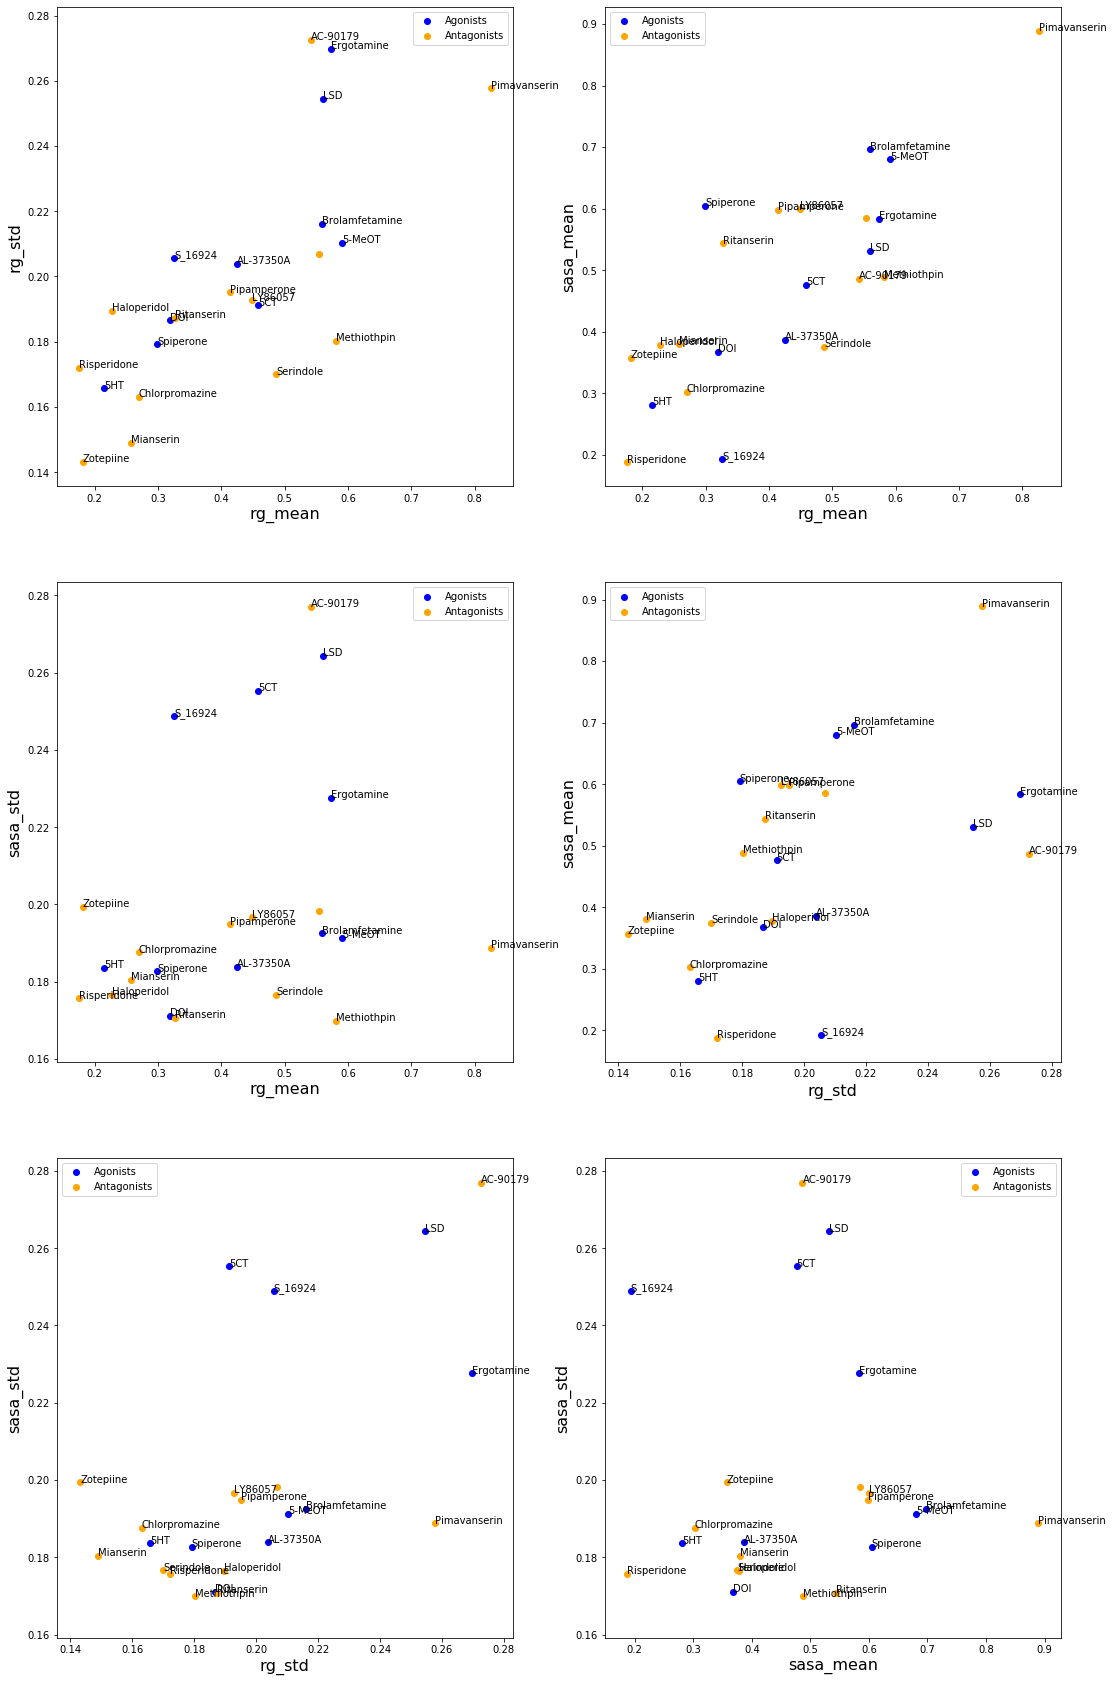

In [6]:
fig = plt.figure(figsize=(18, 30))
plot_index = 1

# We will have 2 plots per row
feature_eval_cols = 2
feature_eval_rows = np.ceil(len(possible_plots) / feature_eval_cols)

#  List of ligand names we will use for the annoation of the dots
ligand_names = [which_drug[1].drug_name for which_drug 
                    in analysis_actors_dict['Agonists'][1:] + analysis_actors_dict['Antagonists']]

# Iterate on all the pair combination of the features we are evaluating
for pair in possible_plots:
    ax = fig.add_subplot(feature_eval_rows, feature_eval_cols, plot_index)
    
    plt.scatter(evaluated_features[pair[0]][:len(analysis_actors_dict['Agonists'])], 
                evaluated_features[pair[1]][:len(analysis_actors_dict['Agonists'])],
                color="blue", label="Agonists")
    plt.scatter(evaluated_features[pair[0]][len(analysis_actors_dict['Agonists']):], 
                evaluated_features[pair[1]][len(analysis_actors_dict['Agonists']):],
                color="orange", label="Antagonists")
    
    # Add ligand names on the dots of the plot
    for which_drug in range(len(ligand_names)):
        ax.annotate(ligand_names[which_drug], 
                    (evaluated_features[pair[0]][which_drug], evaluated_features[pair[1]][which_drug]))
    
    plt.xlabel(pair[0], fontsize=16)
    plt.ylabel(pair[1], fontsize=16)
    
    plt.legend()
    
    plot_index += 1
    
plt.savefig('figures/rg_sasa_combinations.png')
plt.show()

#### Rg Mean - SASA Mean

While the above cells are useful for quick insights in order to get presentation quality plots we must separately examine and plot the specific cases we want.

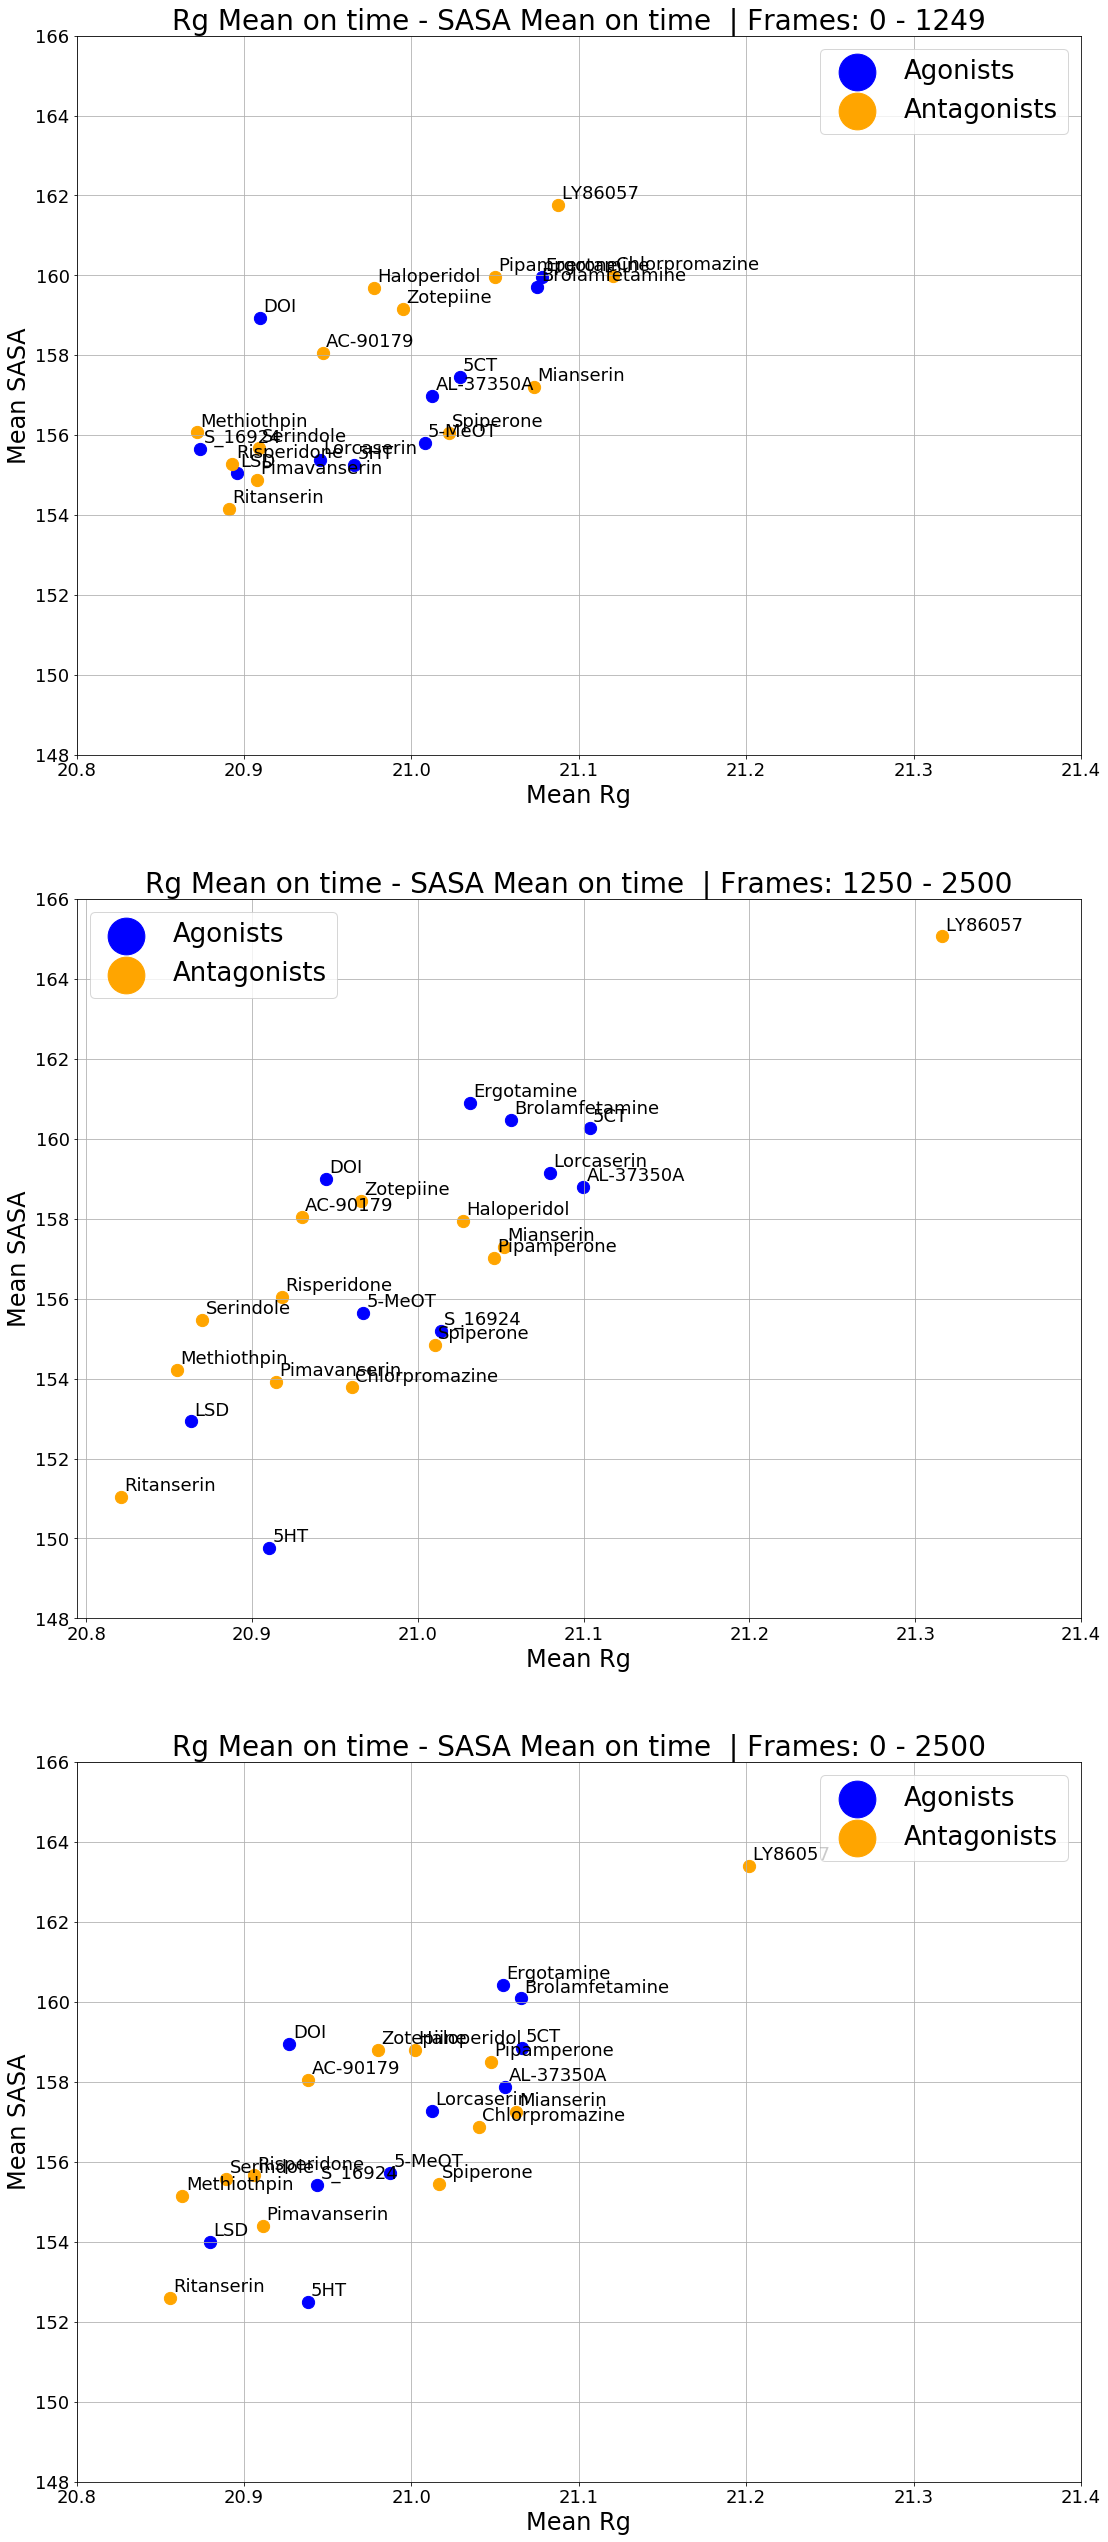

In [84]:
#  Set which windows to be plotted
frame_windows = [[0, 1249], [1250, 2500], [0 , 2500]]

rows = len(frame_windows)
cols=1
plot_index = 1

fig = plt.figure(figsize=(18, 15 * rows))

for start, end in frame_windows:
    ax = fig.add_subplot(rows, cols, plot_index)
    
    # Get the dot points coordinates
    agonists_rg_mean = np.mean(rg_stacked[:len(analysis_actors_dict['Agonists']), start:end + 1], axis=1)
    antagonists_rg_mean = np.mean(rg_stacked[len(analysis_actors_dict['Agonists']):, start:end + 1], axis=1)
        
    agonists_sasa_mean = np.mean(sasa_stacked[:len(analysis_actors_dict['Agonists']), start:end + 1], axis=1)
    antagonists_sasa_mean = np.mean(sasa_stacked[len(analysis_actors_dict['Agonists']):, start:end + 1], axis=1)
    
    
    plt.scatter(agonists_rg_mean, agonists_sasa_mean, label="Agonists",color="blue", s=150)
    plt.scatter(antagonists_rg_mean, antagonists_sasa_mean, label="Antagonists", color="orange", s=150)

    # Annotate the plot by putting the name of the ligand on each dot
    for which_drug in range(len(analysis_actors_dict['Agonists'])):
        ax.annotate(analysis_actors_dict['Agonists'][which_drug][1].drug_name, 
                    (agonists_rg_mean[which_drug] + 0.002, 
                     agonists_sasa_mean[which_drug] + 0.15),
                     fontsize=18)

    for which_drug in range(len(analysis_actors_dict['Antagonists'])):
        ax.annotate(analysis_actors_dict['Antagonists'][which_drug][1].drug_name, 
                    (antagonists_rg_mean[which_drug] + 0.002, 
                     antagonists_sasa_mean[which_drug] + 0.15),
                    fontsize=18)

    plt.xlabel("Mean Rg", fontsize=24)
    plt.xticks(np.arange(20.8, 21.5, 0.1), fontsize=18)
    plt.yticks(np.arange(148, 168, 2), fontsize=18)
    plt.ylabel("Mean SASA", fontsize=24)
    plt.title(f"Rg Mean on time - SASA Mean on time  | Frames: {start} - {end}", fontsize=28)
    plt.legend(prop={'size': 26}, markerscale=3)
    plt.grid()

    plot_index += 1

plt.savefig('figures/combined/rg_sasa_mean.png', format='png')

plt.show()

#### Rg std - SASA std

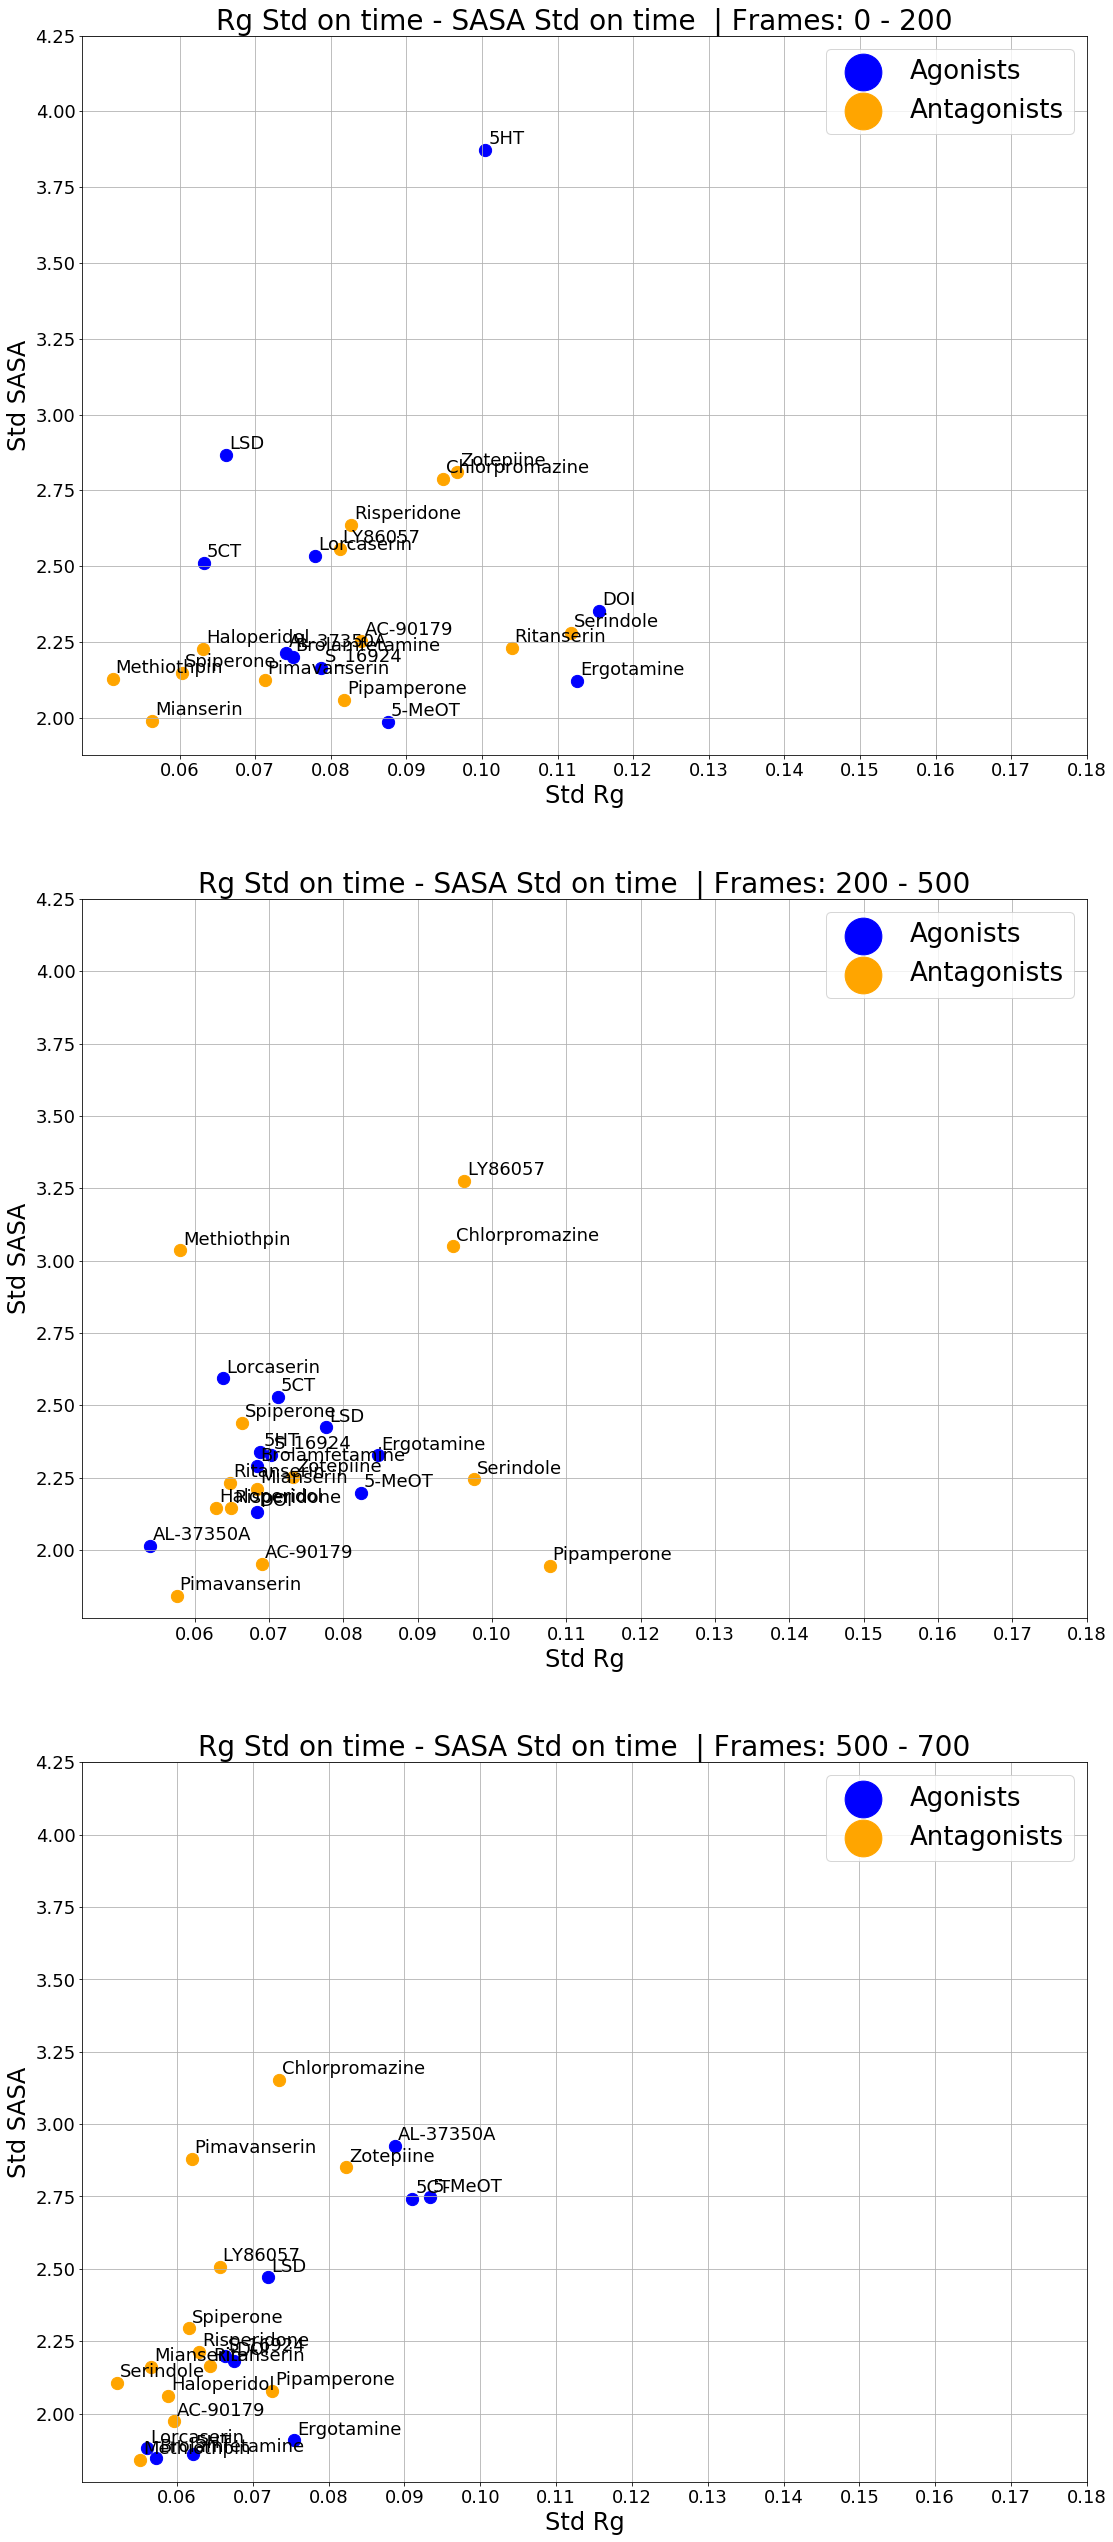

In [87]:
#  Set which windows to be plotted
frame_windows = [[0, 200], [200, 500], [500 , 700]]

rows = len(frame_windows)
cols=1
plot_index = 1

fig = plt.figure(figsize=(18, 15 * rows))

for start, end in frame_windows:
    ax = fig.add_subplot(rows, cols, plot_index)
    
    # Get the dot points coordinates
    agonists_rg_std = np.std(rg_stacked[:len(analysis_actors_dict['Agonists']), start:end + 1], axis=1)
    antagonists_rg_std = np.std(rg_stacked[len(analysis_actors_dict['Agonists']):, start:end + 1], axis=1)
        
    agonists_sasa_std = np.std(sasa_stacked[:len(analysis_actors_dict['Agonists']), start:end + 1], axis=1)
    antagonists_sasa_std = np.std(sasa_stacked[len(analysis_actors_dict['Agonists']):, start:end + 1], axis=1)
    
    # Dot points of the agonists
    plt.scatter(agonists_rg_std, agonists_sasa_std, label="Agonists", color="blue", s=150)
    # Dot points of the antagonists
    plt.scatter(antagonists_rg_std, antagonists_sasa_std, label="Antagonists", color="orange", s=150)

    # Annotate the plot by putting the name of the ligand on each dot
    for which_drug in range(len(analysis_actors_dict['Agonists'])):
        ax.annotate(analysis_actors_dict['Agonists'][which_drug][1].drug_name, 
                    (agonists_rg_std[which_drug] + 0.0004, 
                     agonists_sasa_std[which_drug] + 0.02),
                     fontsize=18)

    for which_drug in range(len(analysis_actors_dict['Antagonists'])):
        ax.annotate(analysis_actors_dict['Antagonists'][which_drug][1].drug_name, 
                    (antagonists_rg_std[which_drug] + 0.0004, 
                     antagonists_sasa_std[which_drug] + 0.02),
                    fontsize=18)

    plt.xlabel("Std Rg", fontsize=24)
    plt.xticks(np.arange(0.06, 0.19, 0.01), fontsize=18)
    plt.yticks(np.arange(2, 4.5, 0.25), fontsize=18)
    plt.ylabel("Std SASA", fontsize=24)
    plt.title(f"Rg Std on time - SASA Std on time  | Frames: {start} - {end}", fontsize=28)
    plt.legend(prop={'size': 26}, markerscale=3)
    plt.grid()
    
    plot_index += 1


plt.savefig('figures/combined/rg_sasa_std.png')
plt.show()

## Independent Experiments

On this part of the notebook I will perform and temporarily store calculations that are not being performed on the `AnalysisActor` object.  
More technically, this means that we can avoid running the time consuming `perform_analysis` method at the start of the notebook.

### Distance between R3.50 (Arg105) and E6.30 (Glu209) of 5HT2A

On the proposal empasis is given on the ionic lock pair R3.50 and E6.30. On the following cell I am reproducing the experiment.

In [ ]:
# Read the Ergotamine simulation
erg_u = MDAnalysis.Universe("../datasets/New_AI_MD/Agonists/Ergotamine/5HT2A_Ergotamine_1st_com_gro.pdb", 
                            "../datasets/New_AI_MD/Agonists/Ergotamine/5TH2A_Ergotamine_500ns_2500frames.xtc")

# Calculate the distance between Arg105 and Glu209 as frames progress
dists_saved = [dist_analysis.dist(erg_u.select_atoms('bynum 1711'), erg_u.select_atoms('bynum 3388'))[2][0]
                  for ts in erg_u.trajectory]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(np.arange(len(dists_saved)), dists_saved, label="Ergotamine")
plt.ylabel("Distance")
plt.xlabel("Frame")
plt.title("Ergotamine Arg105, Glu209 Distance")
plt.show()

The result matches the first half of the proposal plot (below), which is expected since the simulation I used is 500ns.

<img src="https://drive.google.com/uc?export=view&id=1Faa4-dCwtT-YvRCelIaWqMgEwUhXR1wI" alt="drawing" width="400"/>


I proceed with calculating the same residue distance for all the agonists and antagonists.

In [ ]:
fig = plt.figure(figsize=(18, 40))
plot_index = 1

# Agonists Iteration
for which_drug in tqdm(analysis_actors_dict['Agonists'], desc="Agonists Distance"):
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    dists_saved = [dist_analysis.dist(which_drug[1].uni.select_atoms('bynum 1711'), erg_u.select_atoms('bynum 3388'))[2][0]
                  for ts in which_drug[1].uni.trajectory]
    plt.plot(np.arange(len(dists_saved)), dists_saved, color='blue')
    plt.ylabel("Distance")
    plt.title(which_drug[1].drug_name)
    plot_index += 1

# Antagonists Iteration
for which_drug in tqdm(analysis_actors_dict['Antagonists'], desc="Antagonists Distance"):
    ax = fig.add_subplot(plot_rows, plot_cols, plot_index)
    dists_saved = [dist_analysis.dist(which_drug[1].uni.select_atoms('bynum 1711'), erg_u.select_atoms('bynum 3388'))[2][0]
                  for ts in which_drug[1].uni.trajectory]
    plt.plot(np.arange(len(dists_saved)), dists_saved, color='orange')
    plt.ylabel("Distance")
    plt.title(which_drug[1].drug_name)
    plot_index += 1



fig.suptitle('Arg105 and Glu209 Distances\nAgonists: Blue\nAntagonists: Orange', fontsize=26, y = 0.93)
plt.show()

We observe the same sudden increases on Lorcaserin (agonist), LSD (agonist) and Methiothpin (antagonist). Although, I am not able to consider this specific distance enough for differentiating agonists and antagonists, it gives us motive to further perform an analysis on the pairwise distances.  

TODOs:
1. Fix summary report